In [1]:
# keras 2.1.2

'/workspace/nas100_vol2/projects/04_PFT/src/FIRST_VISITS_entire_set/Training'

In [1]:
img_width, img_height = 180,178
epochs =150
batch_size = 10

In [2]:
  #이거 어떻게 집어 넣지# 최소 8이라고 해서.

In [3]:
# node_name = "12"

In [4]:
slice_interval = 1

In [5]:
col_y = "FVC_MEAS"

In [6]:
_random_y = False
_augmentation = False
#-------
NUM_CH = 1
NUM_FRAMES = 140
slice_interval = 1
#--------
INITIAL_LR = 0.001
#----------------------------
tr_num = f"PFT_FV_entire_v3_i3d_incepV1_{col_y}_{NUM_CH}ch_nf{NUM_FRAMES}_01"
print(tr_num)



PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import glob
import SimpleITK as sitk

import random

In [8]:
from datetime import datetime
print()
now = datetime.now().strftime("%y%m%d")
print(now)
print(datetime.now())


210915
2021-09-15 03:03:33.468908


In [9]:
!nvidia-smi

Wed Sep 15 03:03:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:1B:00.0 Off |                  N/A |
| 41%   32C    P8    25W / 280W |   3244MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:1C:00.0 Off |                  N/A |
| 41%   

In [10]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [11]:
import keras
keras.backend.image_data_format()
print(keras.__version__)

Using TensorFlow backend.


2.1.2


In [2]:
from platform import python_version

print(python_version())

3.6.8


In [3]:
from keras import backend as K

print(K.backend())


Using TensorFlow backend.


tensorflow


In [5]:
import tensorflow as tf; print(tf.__version__)

1.15.0


In [17]:
os.getcwd()

'/workspace/nas100_vol2/projects/04_PFT/src/FIRST_VISITS_entire_set/Training/training_v3_entire'

In [18]:
os.chdir("/workspace/nas100_vol2/projects/04_PFT/src/FIRST_VISITS_entire_set/Training")

In [19]:
# 첫번째 방법


import keras
from keras.preprocessing import image
from keras import backend as K

#------
from i3d_inception_last_global import Inception_Inflated3d as I3d
from i3d_inception_last_global import conv3d_bn

#------
from keras.models import Model
from keras import layers
from keras.layers import Activation
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Conv3D
from keras.layers import MaxPooling3D
from keras.layers import AveragePooling3D
from keras.layers import Dropout
from keras.layers import Reshape
from keras.layers import Lambda
from keras.layers import GlobalAveragePooling3D



K.clear_session()

n_classes = 1


###################################
# base model - 마지막 부분을 global average pooling으로 고침
###################################

base_model = I3d(include_top=False,
                weights=None,
#                 input_tensor=None,
                input_shape=(NUM_FRAMES,178,180,NUM_CH),
#                 dropout_prob=0.0,
                endpoint_logit=False, # softmax will be applied
                classes=n_classes
                ) 


# base_model.load_weights(weight_path)


##################################
# base model에서 마지막 average pooling을  제한다. - Global average pooling 이라고 되어 있는데  average pooling으로 되어 있어서.
##################################

x = base_model.output


# #################################
# # 아랫단은 v3에서 기반한 inflation 모델과 같게 한다.
# #################################

x = base_model.output
# x = Dropout(0.0)(x)
x = Dense(500, activation = "relu")(x)
# x = Dense(500, activation = "relu")(x)
prediction = Dense(1,activation = "linear" )(x)

#----------------------------------

model = Model(inputs=base_model.input, outputs=prediction)




In [20]:
from keras.utils import plot_model

plot_model(model, to_file=f"model_{tr_num}.png", show_shapes=True)  # 2.1.2.에서는 되고 .2.3.1에서는 안되는 문제.제기랄
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 140, 178, 180 0                                            
__________________________________________________________________________________________________
Conv3d_1a_7x7_conv (Conv3D)     (None, 70, 89, 90, 6 21952       input_1[0][0]                    
__________________________________________________________________________________________________
Conv3d_1a_7x7_bn (BatchNormaliz (None, 70, 89, 90, 6 192         Conv3d_1a_7x7_conv[0][0]         
__________________________________________________________________________________________________
Conv3d_1a_7x7 (Activation)      (None, 70, 89, 90, 6 0           Conv3d_1a_7x7_bn[0][0]           
__________________________________________________________________________________________________
MaxPool2d_

In [21]:
# compile

from keras.optimizers import SGD,RMSprop,Adam
# #opt = SGD(lr=1e-2, momentum=0.9, decay=1e-2/epochs)
opt = Adam(lr=INITIAL_LR)


model.compile(optimizer=opt, loss='mse', metrics = ["mse", "mae"])

In [22]:
!nvidia-smi

Wed Sep 15 03:06:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:1B:00.0 Off |                  N/A |
| 41%   32C    P8    25W / 280W |   3244MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:1C:00.0 Off |                  N/A |
| 41%   

In [23]:
#change path to your PC environment./
PATH_project = '/workspace/nas100_vol2/projects/04_PFT/'
PATH_data ="/workspace/lung_pft/_LDCT_preprocessing_v3/03_crop_padded"
# input_folder = 'PFT_FV_2018_03_crop_padded'
# PATH_input = os.path.join(PATH_data, input_folder)
PATH_info = os.path.join(PATH_project, "data", "00_DATA_info")

TASK = 'PFT_FV_entire_regression_with_preprocessing_v3'

PATH_task = os.path.join(PATH_project, TASK)
if not os.path.isdir(PATH_task):
    os.mkdir(PATH_task)

PATH_trial = os.path.join(PATH_task, tr_num)
if not os.path.isdir(PATH_trial):
    os.mkdir(PATH_trial)
    
PATH_log = os.path.join("/workspace/nas100_vol2", "projects/04_PFT/result/_log")

def print_paths():
    print("PATH_project: ", PATH_project)
    print("PATH_data: ", PATH_data)
#     print("PATH_input: ", PATH_input)
    print("PATH_info: ", PATH_info)
    print("-----------------------")
    print("PATH_task: ", PATH_task)
    print("PATH_trial: ", PATH_trial)
    print("PATH_log: ", PATH_log)           


In [24]:
print_paths()

PATH_project:  /workspace/nas100_vol2/projects/04_PFT/
PATH_data:  /workspace/lung_pft/_LDCT_preprocessing_v3/03_crop_padded
PATH_info:  /workspace/nas100_vol2/projects/04_PFT/data/00_DATA_info
-----------------------
PATH_task:  /workspace/nas100_vol2/projects/04_PFT/PFT_FV_entire_regression_with_preprocessing_v3
PATH_trial:  /workspace/nas100_vol2/projects/04_PFT/PFT_FV_entire_regression_with_preprocessing_v3/PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01
PATH_log:  /workspace/nas100_vol2/projects/04_PFT/result/_log


In [25]:
os.listdir(PATH_data)

['Lung_PFT_00001~05000',
 'Lung_PFT_10001~15000',
 'Lung_PFT_05001~10000',
 'Lung_PFT_15001~20000',
 'Lung_PFT_20001~25000',
 'Lung_PFT_25001~30000',
 'Lung_PFT_50001~',
 'Lung_PFT_45001~50000',
 'Lung_PFT_40001~45000',
 'Lung_PFT_30001~35000',
 'Lung_PFT_35001~40000']

# 0. check Dataset construction

In [26]:
"/workspace/nas100_vol2/projects/04_PFT/data/00_DATA_info/PFT_LDCT_info(0806)/PFT_LDCT_fv_filtered_with_path(210429).xlsx"
"/workspace/lung_pft/_LD_CT_resampled/03_crop_padded/PFT_LDCT_fv_filtered_resampled_with_inferresult(0430).xlsx"

'/workspace/lung_pft/_LD_CT_resampled/03_crop_padded/PFT_LDCT_fv_filtered_resampled_with_inferresult(0430).xlsx'

In [27]:
df_info = pd.read_excel("/workspace/nas100_vol2/projects/04_PFT/data/00_DATA_info/PFT_LDCT_info(0806)/PFT_LDCT_fv_filtered_with_path(210429).xlsx", 
                        index_col = 0, 
                       engine = "openpyxl")

In [28]:
list_new_key = []
for _key in df_info.keys():
    _new_key = _key.strip()
    list_new_key.append(_new_key)

In [29]:
df_info.columns = list_new_key

In [30]:
df_info = df_info[df_info[col_y].notnull()]

In [31]:
df_info.keys()

Index(['examID', 'ID_path', 'dir_name', 'target_path', 'check_dir_exist',
       '연구번호', 'HE0108(R5253A)검사접수번호', 'HE0109(R5253)검사접수번호', 'EXCEL',
       'PYTHON', 'sex', 'exam_date', 'age', '내원번호', 'Ht', 'Wt', 'BMI', 'AC',
       'SBP', 'DBP', 'Q0002 귀하께서는 암을 진단 받은 적이 있습니까?',
       'Q0003 진단 받은 암을 선택해 주시겠습니까? (복수 응답 가능)',
       'Q0214 폐질환, 신장/요로/전립선질환, 간/담도질환, 식도/위/대장질환 및 갑상선 질환이 있습니까?',
       'Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)',
       'Q0012 복용/주사 중인 약을 선택해 주시겠습니까? (복수 응답 가능)',
       'Q0016 시술 혹은 수술을 선택해주시겠습니까?(복수 응답 가능)', 'Q0047 귀하는 담배를 피운적이 있습니까?',
       'Q0048 처음 흡연을 시작한 연령은 몇 세입니까?', 'Q0049 흡연을 중단한 연령은 몇 세입니까?',
       'Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 표시바랍니다)',
       'Q0089 숨찬 증상이 있습니까?', 'Q0211 흉부 통증이 있습니까?',
       'Q0090 상기도 및 호흡기계 증상이 있습니까?', 'R5253A 접수일자', 'R5253A 결과본문', 'R5253A 결론',
       'R5253 접수일자', 'R5253 결과본문', 'R5253 결론', 'S2001 접수일자', 'S2001 결론',
       'S2002 접수일자', 'S2002 결론', 'FVC_PRED', 'FVC_MEAS', 'FVC_PRED_percent',
       '

In [32]:
print(df_info.shape)

(13428, 66)


In [33]:
PATH_data

'/workspace/lung_pft/_LDCT_preprocessing_v3/03_crop_padded'

In [34]:
df_info["group_path"].value_counts()

Lung_PFT_35001~40000    1436
Lung_PFT_30001~35000    1406
Lung_PFT_00001~05000    1393
Lung_PFT_20001~25000    1391
Lung_PFT_25001~30000    1380
Lung_PFT_05001~10000    1364
Lung_PFT_15001~20000    1355
Lung_PFT_10001~15000    1322
Lung_PFT_40001~45000    1236
Lung_PFT_45001~50000     714
Lung_PFT_50001~          431
Name: group_path, dtype: int64

In [35]:
def get_path_in_workspace(_row):
    _group_path = _row["group_path"]
    _ID = _row["examID"]
    _path_in_workspace = os.path.join(PATH_data, _group_path, str(_ID) + ".hdr")
    return _path_in_workspace

os.path.isfile(df_info.apply(get_path_in_workspace, axis = 1)[0])

True

In [36]:
df_info["path_in_workspace"] = df_info.apply(get_path_in_workspace, axis = 1)

In [37]:
print(df_info["path_in_workspace"][0])

/workspace/lung_pft/_LDCT_preprocessing_v3/03_crop_padded/Lung_PFT_00001~05000/1652375629.hdr


In [38]:
df_train = df_info[df_info["set_split"] =="train"].reset_index(drop = True)
df_valid = df_info[df_info["set_split"] =="valid"].reset_index(drop = True)


#--------------------------------------------------
 
df_test = df_info[(df_info["set_split"] =="test")].reset_index(drop = True)

In [39]:
def compare_two_groups(df1, df2,\
                      col1, col2,\
                      groupname1, groupname2):
    #---------------------------------------------------
    from scipy.stats import ttest_ind, ranksums
    from scipy.stats import kstest, ks_1samp, ks_2samp 
    from scipy.stats import normaltest
    import scipy
    from statsmodels.stats.diagnostic import kstest_normal
    #--------------------------------------------------
    target_group_1 = df1
    target_group_2 = df2
    values_group_1 = target_group_1[col1]
    values_group_2 = target_group_2[col2]

    name_target_1 = groupname1
    name_target_2 = groupname2
    
    #---- plot
    lim_xmin = min(np.min(values_group_1), np.min(values_group_2))
    lim_xmax = max(np.max(values_group_1), np.max(values_group_2))
    step = (lim_xmax - lim_xmin) / 15
    
    bins = np.arange(lim_xmin,lim_xmax * 1.01,  step)
    plt.hist(values_group_1, label =name_target_1, alpha = 0.3, bins = bins, ec = "k")
    plt.hist(values_group_2, label =name_target_2, alpha = 0.3, bins = bins, ec = "k")
    plt.legend( bbox_to_anchor = (1, -0.07))
    plt.title(col1)
    plt.show()
    
    
    #---- 정규성 검정 
    #https://towardsdatascience.com/methods-for-normality-test-with-application-in-python-bb91b49ed0f5
    alternative_hypothesis = False
    for _value_ar in [values_group_1, values_group_2]:
#         statistic, p_value = kstest(_value_ar, "norm")
#         print("1. scipy kstest ")
#         print("statistic: {}".format(np.round(statistic, 3)))
#         print("p_value: {} ".format(np.round(p_value,3))) 
        
#         statistic, p_value =ks_1samp(_value_ar, scipy.stats.norm.cdf) # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_1samp.html
#         print("2. scipy ks_1samp ")
#         print("statistic: {}".format(np.round(statistic, 3)))
#         print("p_value: {} ".format(np.round(p_value,3))) 
        
        statistic, p_value =kstest_normal(_value_ar, 'norm') # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_1samp.html
        print("3. statsmodelsa.diagnostic.kstest_normal")
        print("statistic: {}".format(np.round(statistic, 3)))
        print("p_value: {} ".format(np.round(p_value,3))) 
        
#         statistic, p_value =normaltest(_value_ar) # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html
#         print("4. scipy.stats.normaltest ")
#         print("statistic: {} ( sum of skewtest z-score and kurtosis z_score)".format(np.round(statistic, 3)))
#         print("p_value: {} ".format(np.round(p_value,3))) 
        
        
        
        
        if p_value <= 0.05 :
              alternative_hypothesis = True
              
    print("is null hypothesis dismissed?", alternative_hypothesis)
              
    
    # 정규성 불만족시
    if alternative_hypothesis == True:
        print("wilcoxon rank sum test using scipy.stats.ranksums")
        statistic, p_value = ranksums(values_group_1,values_group_2 )
        print("statistic: {}".format(np.round(statistic, 3)))
        print("p_value: {} ".format(np.round(p_value,3))) 
        

    #------ 정규성 만족시, 
    else:
        print("t test using scipy.stats.ttest_ind")
        statistic, p_value = ttest_ind(
            a=values_group_1, 
            b=values_group_2, 
            equal_var=False # variance equal.
        )
        print("statistic: {}".format(np.round(statistic, 3)))
        print("p_value: {} ".format(np.round(p_value,3)))

    df_info = pd.DataFrame({name_target_1: [int(len(values_group_1)), values_group_1.mean(), values_group_1.std()], 
                name_target_2: [int(len(values_group_2)),values_group_2.mean(), values_group_2.std()]}, 
                index = ["size", "mean", "std"])
    print(df_info)
    print("\n\n\n")
    return df_info



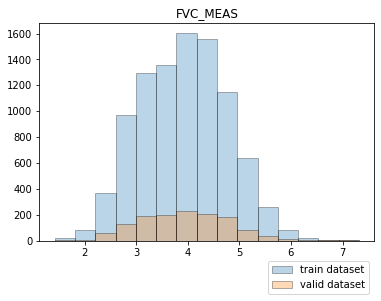

3. statsmodelsa.diagnostic.kstest_normal
statistic: 0.032
p_value: 0.001 
3. statsmodelsa.diagnostic.kstest_normal
statistic: 0.04
p_value: 0.001 
is null hypothesis dismissed? True
wilcoxon rank sum test using scipy.stats.ranksums
statistic: -0.819
p_value: 0.413 
      train dataset  valid dataset
size    9398.000000    1343.000000
mean       3.914488       3.942576
std        0.831036       0.844235






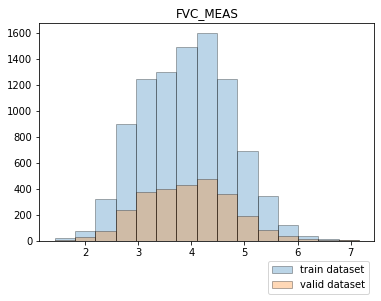

3. statsmodelsa.diagnostic.kstest_normal
statistic: 0.032
p_value: 0.001 
3. statsmodelsa.diagnostic.kstest_normal
statistic: 0.032
p_value: 0.001 
is null hypothesis dismissed? True
wilcoxon rank sum test using scipy.stats.ranksums
statistic: 0.148
p_value: 0.882 
      train dataset  valid dataset
size    9398.000000    2687.000000
mean       3.914488       3.912869
std        0.831036       0.808033






,train dataset,valid dataset
size,9398.000000,2687.000000
mean,3.914488,3.912869
std,0.831036,0.808033


In [40]:
compare_two_groups(df_train, df_valid,\
                  col_y, col_y,\
                  "train dataset", "valid dataset")

compare_two_groups(df_train, df_test,\
                  col_y, col_y,\
                  "train dataset", "valid dataset")
    

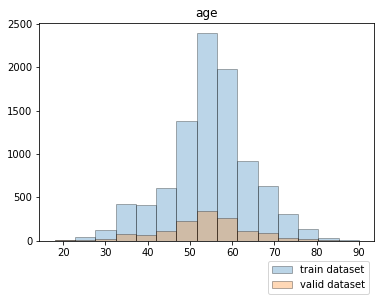

3. statsmodelsa.diagnostic.kstest_normal
statistic: 0.074
p_value: 0.001 
3. statsmodelsa.diagnostic.kstest_normal
statistic: 0.069
p_value: 0.001 
is null hypothesis dismissed? True
wilcoxon rank sum test using scipy.stats.ranksums
statistic: 3.73
p_value: 0.0 
      train dataset  valid dataset
size    9398.000000    1343.000000
mean      54.698553      53.680566
std        9.818666       9.777935






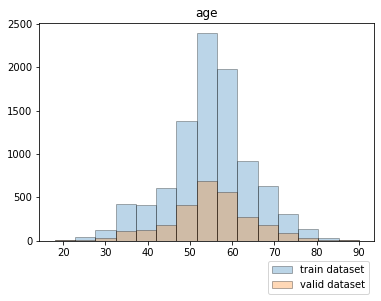

3. statsmodelsa.diagnostic.kstest_normal
statistic: 0.074
p_value: 0.001 
3. statsmodelsa.diagnostic.kstest_normal
statistic: 0.065
p_value: 0.001 
is null hypothesis dismissed? True
wilcoxon rank sum test using scipy.stats.ranksums
statistic: -0.126
p_value: 0.9 
      train dataset  valid dataset
size    9398.000000    2687.000000
mean      54.698553      54.797172
std        9.818666       9.461456






,train dataset,valid dataset
size,9398.000000,2687.000000
mean,54.698553,54.797172
std,9.818666,9.461456


In [41]:
compare_two_groups(df_train, df_valid,\
                  "age", "age",\
                  "train dataset", "valid dataset")

compare_two_groups(df_train, df_test,\
                  "age", "age",\
                  "train dataset", "valid dataset")
    

In [42]:
df_train.keys()

Index(['examID', 'ID_path', 'dir_name', 'target_path', 'check_dir_exist',
       '연구번호', 'HE0108(R5253A)검사접수번호', 'HE0109(R5253)검사접수번호', 'EXCEL',
       'PYTHON', 'sex', 'exam_date', 'age', '내원번호', 'Ht', 'Wt', 'BMI', 'AC',
       'SBP', 'DBP', 'Q0002 귀하께서는 암을 진단 받은 적이 있습니까?',
       'Q0003 진단 받은 암을 선택해 주시겠습니까? (복수 응답 가능)',
       'Q0214 폐질환, 신장/요로/전립선질환, 간/담도질환, 식도/위/대장질환 및 갑상선 질환이 있습니까?',
       'Q0229 과거력(폐,비뇨기,소화기,갑상선) 을 선택해 주시겠습니까? (복수 응답 가능)',
       'Q0012 복용/주사 중인 약을 선택해 주시겠습니까? (복수 응답 가능)',
       'Q0016 시술 혹은 수술을 선택해주시겠습니까?(복수 응답 가능)', 'Q0047 귀하는 담배를 피운적이 있습니까?',
       'Q0048 처음 흡연을 시작한 연령은 몇 세입니까?', 'Q0049 흡연을 중단한 연령은 몇 세입니까?',
       'Q0050 하루 평균 흡연량은 얼마입니까? (현재 끊으신분도 과거 하루 평균 흡연량 표시바랍니다)',
       'Q0089 숨찬 증상이 있습니까?', 'Q0211 흉부 통증이 있습니까?',
       'Q0090 상기도 및 호흡기계 증상이 있습니까?', 'R5253A 접수일자', 'R5253A 결과본문', 'R5253A 결론',
       'R5253 접수일자', 'R5253 결과본문', 'R5253 결론', 'S2001 접수일자', 'S2001 결론',
       'S2002 접수일자', 'S2002 결론', 'FVC_PRED', 'FVC_MEAS', 'FVC_PRED_percent',
       '

# 1. define augmentation

In [36]:
"""
Augmenters that apply to a group of augmentations, like selecting
an augmentation from a list, or applying all the augmentations in
a list sequentially
To use the augmenters, clone the complete repo and use
`from vidaug import augmenters as va`
and then e.g. :
    seq = va.Sequential([ va.HorizontalFlip(),
                          va.VerticalFlip() ])
List of augmenters:
    * Sequential
    * OneOf
    * SomeOf
    * Sometimes
"""

import numpy as np
import PIL
import random


class Sequential(object):
    """
    Composes several augmentations together.
    Args:
        transforms (list of "Augmentor" objects): The list of augmentations to compose.
        random_order (bool): Whether to apply the augmentations in random order.
    """

    def __init__(self, transforms, random_order=False):
        self.transforms = transforms
        self.rand = random_order

    def __call__(self, clip):
        if self.rand:
            rand_transforms = self.transforms[:]
            random.shuffle(rand_transforms)
            for t in rand_transforms:
                clip = t(clip)
        else:
            for t in self.transforms:
                clip = t(clip)

        return clip




class Sometimes(object):
    """
    Applies an augmentation with a given probability.
    Args:
        p (float): The probability to apply the augmentation.
        transform (an "Augmentor" object): The augmentation to apply.
    Example: Use this this transform as follows:
        sometimes = lambda aug: va.Sometimes(0.5, aug)
        sometimes(va.HorizontalFlip)
    """

    def __init__(self, p, transform):
        self.transform = transform
        if (p > 1.0) | (p < 0.0):
            raise TypeError('Expected p to be in [0.0 <= 1.0], ' +
                            'but got p = {0}'.format(p))
        else:
            self.p = p

    def __call__(self, clip):
        if random.random() < self.p:
            clip = self.transform(clip)
        return clip
    


In [37]:
import numpy as np
import numbers
import random
from skimage import transform
import PIL
import cv2


class RandomRotate(object):
    """
    Rotate video randomly by a random angle within given boundsi.
    Args:
        degrees (sequence or int): Range of degrees to randomly
        select from. If degrees is a number instead of sequence
        like (min, max), the range of degrees, will be
        (-degrees, +degrees).
    """

    def __init__(self, degrees):
        if isinstance(degrees, numbers.Number):
            if degrees < 0:
                raise ValueError('If degrees is a single number,'
                                 'must be positive')
            degrees = (-degrees, degrees)
        else:
            if len(degrees) != 2:
                raise ValueError('If degrees is a sequence,'
                                 'it must be of len 2.')

        self.degrees = degrees

    def __call__(self, clip):
        angle = random.uniform(self.degrees[0],self.degrees[1])
        if isinstance(clip[0], np.ndarray):
            rotated = [transform.rotate(img, angle, mode='edge') for img in clip]
        elif isinstance(clip[0], PIL.Image.Image):
            rotated = [img.rotate(angle) for img in clip]
        else:
            raise TypeError('Expected numpy.ndarray or PIL.Image' +
                            'but got list of {0}'.format(type(clip[0])))

        return rotated

In [38]:
sometimes = lambda aug: Sometimes(0.4, aug)
aug = Sequential([sometimes(RandomRotate(degrees = 10))])

In [39]:
def random_hide(_img):
    random_alpha = random.uniform(0,0.5)
    
    _y_crop = np.random.randint(8,24)
    
    _z_crop_1 = np.random.randint(30, _img.shape[1]-60)
    _x_crop_1 = np.random.randint(30, _img.shape[2]-60)
    _img[_y_crop:_y_crop+8, _z_crop_1:_z_crop_1+30, _x_crop_1:_x_crop_1+30, :] = 0
    return _img

In [40]:
os.getcwd()

'/workspace/nas100_vol2/projects/04_PFT/src/FIRST_VISITS_entire_set/Training'

# 2. check input: how to load the data

In [43]:
id_train = list(range(len(df_train)))  # id_train이 불러 올 train data의 idx이다. 데이터 프레임을 섞지 않고 불러 올 인덱스를 섞으면 된다.
id_valid = list(range(len(df_valid)))
random.seed(0)
for i in range(20):
    random.shuffle(id_train)
    random.shuffle(id_valid)

In [44]:

def preprocess_image(input_img):    # AMC lung windowing
#     density_low = -1024
#     density_high = 3071
    LEVEL = -700
    WIDTH = 1500
    density_low = LEVEL - WIDTH/2
    density_high = LEVEL + WIDTH/2
#     print(density_low, density_high)
    
    output_img = (input_img-density_low) / (density_high-density_low+1)   
    output_img[output_img < 0.] = 0.
    output_img[output_img > 1.] = 1.
    
    return output_img





def preprocess_12bit(input_img):    # 12 bit full range 
    density_low = -1024
    density_high = 3071
  
    output_img = (input_img-density_low) / (density_high-density_low+1)   
    output_img[output_img < 0.] = 0.
    output_img[output_img > 1.] = 1.
    
    return output_img



def preprocess_media(input_img):   
#     density_low = -1024
#     density_high = 3071
    LEVEL = 50
    WIDTH = 500
    density_low = LEVEL - WIDTH/2
    density_high = LEVEL + WIDTH/2
#     print(density_low, density_high)
    
    output_img = (input_img-density_low) / (density_high-density_low+1)   
    output_img[output_img < 0.] = 0.
    output_img[output_img > 1.] = 1.
    
    return output_img


In [45]:
def load_image(path,augmentation = False, num_channel = NUM_CH):
    img = sitk.GetArrayFromImage(sitk.ReadImage(path)) # 3d image를 불러 와야 함. (z, y, x)
    
#     print("min: ", np.min(img), "\tmax: ", np.max(img))

#     if NUM_FRAMES >100:
#         range_min = 0
#         list_range = np.arange(range_min, range_min + NUM_FRAMES, 1)
#----------------   
    
#     if num_channel ==3:
#         _1st = preprocess_image(img)
#         _2nd = preprocess_media(img)
#         _3rd = preprocess_12bit(img)



#         for _, _idx in enumerate(list_range):
#             _1st_y = np.flipud(_1st[:, _idx, :])
#             _2nd_y = np.flipud(_2nd[:, _idx, :])
#             _3rd_y = np.flipud(_3rd[:, _idx, :])
#             img_tmp = np.stack([_1st_y, _2nd_y, _3rd_y], axis = -1)



#             img_tmp = np.expand_dims(img_tmp, axis = 0)

#             if _ == 0:
#                 img_out = img_tmp[:]
#             else:
#                 img_out = np.concatenate([img_out, img_tmp], axis = 0)

#         if augmentation:
#             img_out = aug(img_out)
#             img_out = np.array(img_out)

    # 사실 사용하는 것은 이 부분이다.
    
    if num_channel ==1:
        img_12bit = preprocess_12bit(img) # (z,y,x)
#         # 만약 list_range를 넣고 싶다면. 
#         img_12bit = img_12bit[:, list_range[0]:list_range[-1], :]
        
        img_tmp = np.moveaxis(img_12bit, [0,1], [1,0]) # (y, z, x)
        img_tmp = img_tmp[:, ::-1, : ]# (y, -z, x)
        
        img_tmp = np.expand_dims(img_tmp, axis = -1)
        img_out = img_tmp.copy()

        if augmentation:
            img_out = aug(img_out)
            img_out = np.array(img_out)
            
            
#     elif num_channel ==2:
#         _1st = preprocess_image(img)
#         _2nd = preprocess_media(img)
        
#         for _, _idx in enumerate(list_range):
#             _1st_y = np.flipud(_1st[:, _idx, :])
#             _2nd_y = np.flipud(_2nd[:, _idx, :])

#             img_tmp = np.stack([_1st_y, _2nd_y], axis = -1)
#             img_tmp = np.expand_dims(img_tmp, axis = 0)

#             if _ == 0:
#                 img_out = img_tmp[:]
#             else:
#                 img_out = np.concatenate([img_out, img_tmp], axis = 0)

#         if augmentation:
#             img_out = aug(img_out)
#             img_out = np.array(img_out)
    return img_out

In [46]:
print_paths()

PATH_project:  /workspace/nas100_vol2/projects/04_PFT/
PATH_data:  /workspace/lung_pft/_LDCT_preprocessing_v3/03_crop_padded
PATH_info:  /workspace/nas100_vol2/projects/04_PFT/data/00_DATA_info
-----------------------
PATH_task:  /workspace/nas100_vol2/projects/04_PFT/PFT_FV_entire_regression_with_preprocessing_v3
PATH_trial:  /workspace/nas100_vol2/projects/04_PFT/PFT_FV_entire_regression_with_preprocessing_v3/PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01
PATH_log:  /workspace/nas100_vol2/projects/04_PFT/result/_log


In [47]:
df_train_shuffled = df_train.sample(frac = 1, random_state = 0).reset_index(drop = True)

In [48]:
# df_train_shuffled

In [ ]:
# draw sample
for i, _row in df_train_shuffled[:1].iterrows():
    print(i)
#     _class = _row["Class"]
    _path= _row["path_in_workspace"]
    _examID = _row["examID"]
    img = load_image(_path)
    print(img.shape)
    print( _examID)
    print(_path)

    n_cols = 8
    if NUM_FRAMES % n_cols==0:
        n_rows = NUM_FRAMES // n_cols
    else:
        n_rows = NUM_FRAMES //n_cols +1
    f, a = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = (n_cols *5, n_rows *5))
    
    for _idx in range(NUM_FRAMES):
        _r = _idx // n_cols
        _c = _idx % n_cols
        a[_r, _c].imshow(img[_idx, ...], cmap = "gray", vmin = 0, vmax = 1)
        a[_r, _c].set_title(_idx)
        a[_r, _c].axis("off")
    
    plt.tight_layout()
    plt.show()

In [50]:
import logging
def generator_augment_fx():
    error_count = 0
    while True:
        np.random.seed(epochs)
        np.random.shuffle(id_train)
        for i in range(len(df_train) // batch_size):
            try:
                
                batch_img = np.zeros((batch_size,NUM_FRAMES, 178, 180, NUM_CH))
                batch_target = np.zeros((batch_size,1), dtype=np.float64)

                for j in range(batch_size):
                    _idx = id_train[i*batch_size+j]       # 이거 어디서 섞나요??
                    
                    _filename = df_train.loc[_idx, "path_in_workspace"]
                    
                    img = load_image(_filename, augmentation = _augmentation)
#                     img = data_augmentation(img) # 할 지 말 지 우선 하지 않고 보도록 하자. 

                    _target_value = df_train.loc[_idx, col_y]


#                     plt.imshow(img)
#                     plt.show()

                    batch_img[j] = img
                    batch_target[j] = _target_value
                    
                yield batch_img, batch_target
        
            except (GeneratorExit, KeyboardInterrupt):
                raise
            except:
                # log it and skip the image
                logging.exception("Error processing image {} {}".format(_idx, df_train.loc[_idx, "examID"]))
                error_count += 1
                if error_count > 5:
                    raise
            

            
def generator_tune_fx():
    error_count = 0
    while True:
        np.random.seed(epochs)
        np.random.shuffle(id_valid)
        
        for i in range(len(df_valid) // batch_size):
            try:
                batch_img = np.zeros((batch_size, NUM_FRAMES,178, 180, NUM_CH))
                batch_target = np.zeros((batch_size,1), dtype=np.float64)
                for j in range(batch_size):
                    _idx = id_valid[i*batch_size+j]       # 이거 어디서 섞나요??
                    _filename = df_valid.loc[_idx, "path_in_workspace"]
                    
                    img = load_image(_filename, augmentation = False)     
            
                    _target_value = df_valid.loc[_idx, col_y]

                
                    batch_img[j] = img
                    batch_target[j] = _target_value
                    
                yield batch_img, batch_target
            except (GeneratorExit, KeyboardInterrupt):
                raise
            except:
                # log it and skip the image
                logging.exception("Error processing image {} {}".format(_idx, df_valid.loc[_idx, "examID"]))
                error_count += 1
                if error_count > 5:
                    raise
# ============augmentation    

In [51]:
len(df_valid)

1343

In [52]:
def get_model_memory_usage(model, batch_size=75):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    number_size = 4.0
    if K.floatx() == 'float16':
         number_size = 2.0
    if K.floatx() == 'float64':
         number_size = 8.0

    total_memory = number_size*(batch_size*shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

print('Model size :', get_model_memory_usage(model, batch_size = batch_size), 'GB')

Model size : 18.134 GB


In [52]:
datapath = PATH_project

In [53]:
!sudo pip install livelossplot

You should consider upgrading via the 'pip install --upgrade pip' command.


In [54]:
print_paths()

PATH_project:  /workspace/nas100_vol2/projects/04_PFT/
PATH_data:  /workspace/lung_pft/_LDCT_preprocessing_v3/03_crop_padded
PATH_info:  /workspace/nas100_vol2/projects/04_PFT/data/00_DATA_info
-----------------------
PATH_task:  /workspace/nas100_vol2/projects/04_PFT/PFT_FV_entire_regression_with_preprocessing_v3
PATH_trial:  /workspace/nas100_vol2/projects/04_PFT/PFT_FV_entire_regression_with_preprocessing_v3/PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01
PATH_log:  /workspace/nas100_vol2/projects/04_PFT/result/_log


In [55]:
import keras
from keras.callbacks import ReduceLROnPlateau



# if not os.path.isdir(os.path.join(datapath, FOLDER)): # 이건 PATH_task
#     os.mkdir(os.path.join(datapath, FOLDER))

# if not os.path.isdir(os.path.join(datapath, FOLDER, 'results_01_1')): # 이건 PATH_trial
#     os.mkdir(os.path.join(datapath, FOLDER, 'results_01_1'))
    
if not os.path.isdir(os.path.join(PATH_trial, 'weights')):
    os.mkdir(os.path.join(PATH_trial, 'weights'))
    
mc = keras.callbacks.ModelCheckpoint(os.path.join(PATH_trial, 'weights', 'train_weights_epoch_{epoch:03d}.h5'),
                                     save_weights_only=True, period=1)

if not os.path.isdir(os.path.join(PATH_trial, 'tensorboard_log')):
    os.mkdir(os.path.join(PATH_trial, 'tensorboard_log'))

tb_hist = keras.callbacks.TensorBoard(log_dir=os.path.join(PATH_trial, 'tensorboard_log'), 
                                      histogram_freq=0, write_graph=True, write_images=True)

hist = keras.callbacks.History()

# early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
# callbacks_list = [mc, tb_hist, hist, early_stop, reduce_lr]

from livelossplot import PlotLossesKeras
from keras.callbacks import CSVLogger

# early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)
csv_log   = os.path.join(PATH_log, 'training_{}.csv'.format(tr_num)) # 이걸 어디에 두는 게 좋을까.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, verbose=1,
#                               min_delta=1e-4
                             )
callbacks_list = [mc, tb_hist, hist, reduce_lr, PlotLossesKeras(), CSVLogger(csv_log, append=False, separator=";")] 

In [56]:
print(csv_log)

/workspace/nas100_vol2/projects/04_PFT/result/_log/training_PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01.csv


In [57]:

nb_tune_samples= len(df_valid) #number of total validation data
print(len(df_valid))

1343


In [58]:
len(df_valid) //batch_size

134

In [59]:
# print(datetime.now())

In [60]:
import time

start = time.time()

print(datetime.now())
print(start)

2021-06-11 01:49:40.483545
1623376180.4834776


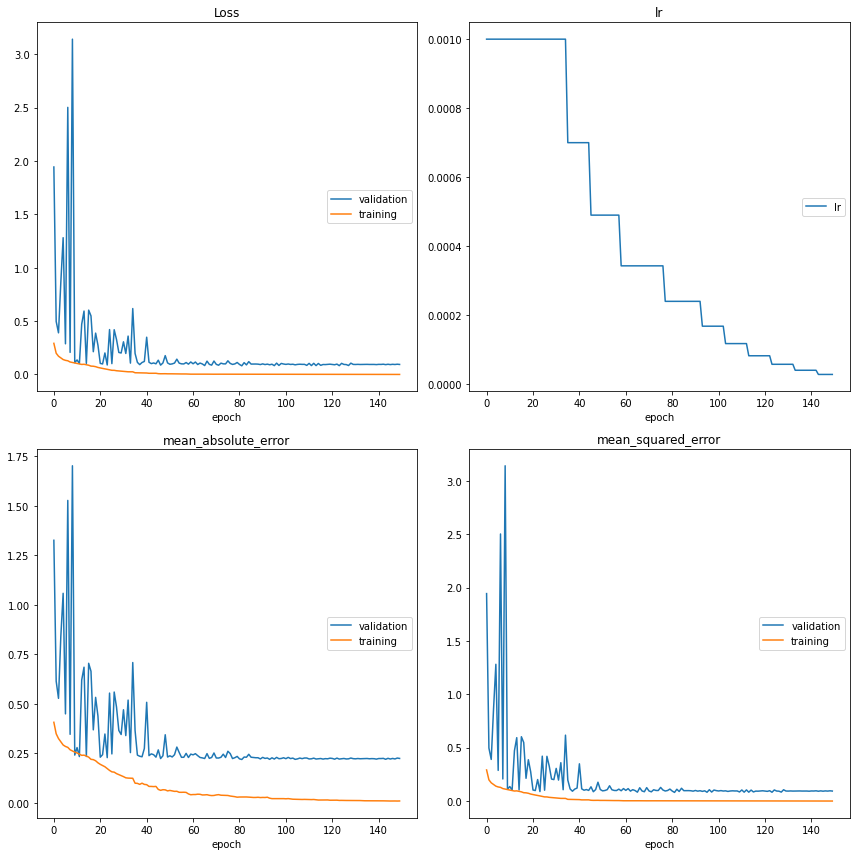

Loss
	validation       	 (min:    0.081, max:    3.142, cur:    0.094)
	training         	 (min:    0.000, max:    0.292, cur:    0.000)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
mean_absolute_error
	validation       	 (min:    0.219, max:    1.702, cur:    0.224)
	training         	 (min:    0.009, max:    0.407, cur:    0.010)
mean_squared_error
	validation       	 (min:    0.081, max:    3.142, cur:    0.094)
	training         	 (min:    0.000, max:    0.292, cur:    0.000)
939/939 [==============================] - 1630s 2s/step - loss: 1.5071e-04 - mean_squared_error: 1.5071e-04 - mean_absolute_error: 0.0096 - val_loss: 0.0938 - val_mean_squared_error: 0.0938 - val_mean_absolute_error: 0.2244


In [61]:
from scipy.ndimage.interpolation import zoom, rotate
from scipy.ndimage.filters import gaussian_filter
# from __future__ import print_function
import argparse
import scipy
import matplotlib.pyplot as plt
%matplotlib inline


print(tr_num)
print(datetime.now())


#from math import ceil
n_points = len(df_train) #train data 갯수
print(n_points)
#steps_per_epoch =ceil(n_points / batch_size)


# model_history = model.fit(
#    X_train_img, y_train_age,
#    validation_data=(X_val_img, y_val_age),
#    epochs=epochs
,
#    callbacks=callbacks_list)
# =================== original code =================================
# model_history = model.fit(
#    X_train_img, y_train_age,
#    validation_data=(X_val_img, y_val_age),
#    epochs=epochs, batch_size=batch_size,
#    callbacks=callbacks_list)
# ====================================================
#model_history = model.fit_generator(generator_fx(), generator_valid_fx(), 
#                                    epochs=epochs, callbacks=callbacks_list)

augment=1

# #code with augmentation
if augment == 1:
    print('with augmentation')
    model_history = model.fit_generator(generator_augment_fx(),
                           steps_per_epoch = len(df_train) // batch_size,
                           epochs=epochs,
                           verbose=1,
                           callbacks=callbacks_list,
                           validation_data=generator_tune_fx(),
                           validation_steps=len(df_valid) //batch_size)  # sksnrl dustks gn 
                           #callbacks=[PlotLossesKeras(), CSVLogger(csv_log,
                            #                append=False,
                             #               separator=";")])


#How to use tensorboard
#Keras callback('tb_hist') automatically make a directory named 'tensorboard_log' in current directory
#Usage : Type 'tensorboard --logdir /absolute/directory/to/current/directory/tensorboard_log'
#        Then type your ip with port 6006(default)
#        e.x.) 123.456.78.90:6006

In [62]:
print(datetime.now())

overall_training_time = time.time() - start
list_weights = os.listdir(os.path.join(PATH_trial, "weights"))
epochs = len(list_weights)
print(epochs)
time_per_epoch = overall_training_time / epochs

2021-06-13 22:48:05.116621
150


In [63]:
print(start)

1623376180.4834776


In [64]:
print(time_per_epoch)

1655.3642217842737


In [65]:
print(tr_num)
print(overall_training_time)
print("total",overall_training_time/60/60/24, "days/", epochs, "epochs" )
print(time_per_epoch/60/60, "hr/epoch")
print(time_per_epoch/60, "min/epoch")

PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01
248304.63326764107
total 2.8738962183754757 days/ 150 epochs
0.45982339494007607 hr/epoch
27.589403696404563 min/epoch


In [66]:
print(datetime.now())

2021-06-14 01:50:17.971143


In [67]:
# print(datetime.now())

In [68]:
print(overall_training_time)

248304.63326764107


In [69]:
print(time_per_epoch)

1655.3642217842737


In [70]:
csv_log

'/workspace/nas100_vol2/projects/04_PFT/result/_log/training_PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01.csv'

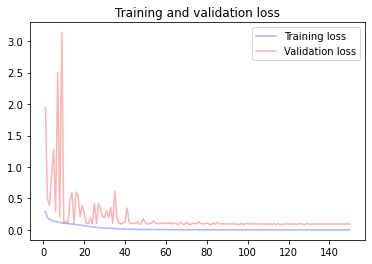

In [71]:

loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)



plt.plot(epochs, loss, 'b-', alpha = 0.3,label = 'Training loss')
plt.plot(epochs, val_loss, 'r-', alpha = 0.3,label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# test

In [ ]:
tr_num


In [ ]:
# tr_num ='PFT_TOY2_i3d_incepV1_FEV1_MEAS_1ch_nf120_01(0222)'

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
import glob
import SimpleITK as sitk
import cv2
import random

In [54]:
!nvidia-smi

Wed Sep 15 03:07:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:1B:00.0 Off |                  N/A |
| 40%   32C    P8    25W / 280W |   3244MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:1C:00.0 Off |                  N/A |
| 41%   

In [55]:
os.getcwd()

'/workspace/nas100_vol2/projects/04_PFT/src/FIRST_VISITS_entire_set/Training'

In [ ]:
# #change path to your PC environment./
# PATH_project = '/workspace/nas100_vol2/projects/04_PFT/'
# PATH_data =os.path.join(PATH_project, "data")
# input_folder = '04_z_fixed'
# PATH_input = os.path.join(PATH_data, input_folder)
# PATH_info = os.path.join(PATH_project, "data", "00_DATA_info")

# CLASS = ['0_over80', "1_under70"]

# TASK = 'PFT_I3D_FVC_regression'

# # PATH_task = os.path.join(PATH_project, TASK)
# # if not os.path.isdir(PATH_task):
# #     os.mkdir(PATH_task)

# # PATH_trial = os.path.join(PATH_task, f"result_{tr_num}")
# # if not os.path.isdir(PATH_trial):
# #     os.mkdir(PATH_trial)
    
# # PATH_log = os.path.join(PATH_project, "result", "_log")
# # if not os.path.isdir(PATH_log):
# #     os.mkdir(PATH_log)



In [58]:
df_log = pd.read_csv(os.path.join(PATH_log, 'training_{}.csv'.format(tr_num)), sep = ";")

# val_mse = df_log.val_mean_squared_error
# val_mae = df_log.val_mean_absolute_error
# val_loss = df_log.val_loss

# list_weights = os.listdir(os.path.join(PATH_trial,'weights'))

# for i, (_v_mse,_v_mae, _v_loss ,_weight)  in enumerate(zip(val_mse,val_mae, val_loss, list_weights)):
#     print(i, i+1,_v_mse,_v_mae, _v_loss, _weight )

In [59]:
df_log.keys()

Index(['epoch', 'loss', 'lr', 'mean_absolute_error', 'mean_squared_error',
       'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error'],
      dtype='object')

In [ ]:
# 1차 plot

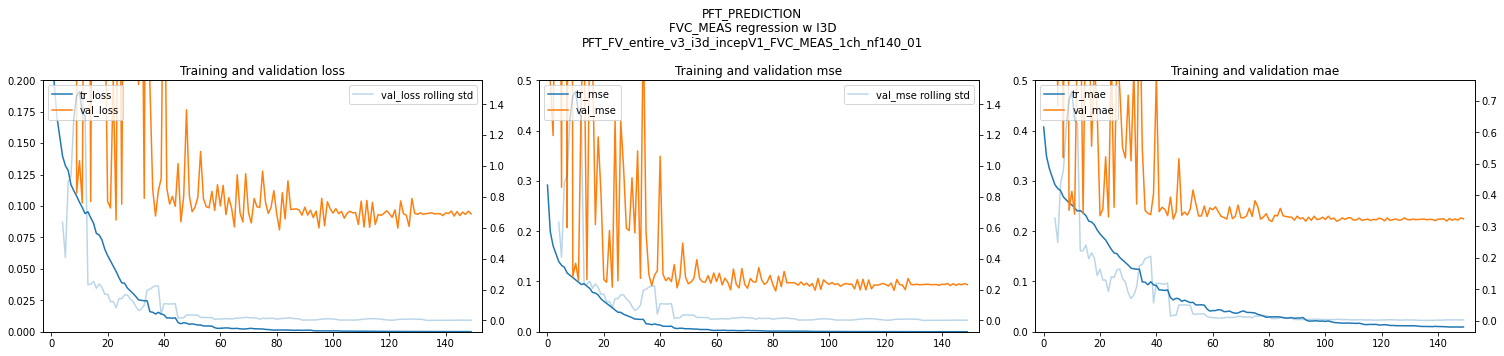

In [61]:
epochs = df_log.epoch

# acc = df_log.acc
# val_acc = df_log.val_acc

loss = df_log.loss
val_loss = df_log.val_loss

mse = df_log.mean_squared_error
val_mse =  df_log.val_mean_squared_error

mae = df_log.mean_absolute_error
val_mae =  df_log.val_mean_absolute_error

#-------------------------------------------------------------



f,a = plt.subplots( nrows = 1, ncols = 3,figsize = (21,5) )
f.suptitle(f"PFT_PREDICTION\n{col_y} regression w I3D\n{tr_num}")


# Plot training and validation loss per epoch
a[0].plot(epochs, loss, label = "tr_loss")
a[0].plot(epochs, val_loss, label = "val_loss")
a[0].set_ylim(0, 0.2)
# n_rolling = 5
# a[0].plot(epochs, val_loss.rolling(n_rolling).mean(), label = "val_loss rolling mean", alpha = 0.3)
a[0].legend(loc = "upper left")

a[0] = a[0].twinx()
n_rolling = 5
a[0].plot(epochs, val_loss.rolling(n_rolling).std(), label = "val_loss rolling std", alpha =0.3)
a[0].legend(loc = "upper right")
a[0].set_title('Training and validation loss')





a[1].plot(epochs, mse, label = "tr_mse")
a[1].plot(epochs, val_mse, label = "val_mse")
a[1].set_ylim(0, 0.5)
# n_rolling = 5
# a[1].plot(epochs, val_mse.rolling(n_rolling).mean(), label = "val_mse rolling mean", alpha = 0.3)
a[1].legend( loc = "upper left")

a[1] = a[1].twinx()
n_rolling = 5
a[1].plot(epochs, val_mse.rolling(n_rolling).std(), label = "val_mse rolling std", alpha = 0.3)
a[1].set_title('Training and validation mse')
a[1].legend( loc = "upper right")


a[2].plot(epochs, mae, label = "tr_mae")
a[2].plot(epochs, val_mae, label = "val_mae")
a[2].legend( loc = "upper left")
a[2].set_ylim(0, 0.5)

a[2] = a[2].twinx()
n_rolling = 5
a[2].plot(epochs, val_mae.rolling(n_rolling).std(), label = "val_mae rolling std", alpha = 0.3)
a[2].set_title('Training and validation mae')

#-------
xlim_min = -3
xlim_max = len(df_log)+3

for i  in [0,1,2]:
    a[i].set_xlim(xlim_min, len(df_log)+3)
#--

plt.tight_layout()
plt.show()

In [75]:
# len(df_log)

In [62]:
val_loss_chosen = val_loss[-10:].idxmin()  + 1
val_mae_chosen = val_mae[-10:].idxmin()  + 1
#----
print(val_mae_chosen)
print(val_loss[val_mae_chosen-1])

print(val_loss_chosen)
print(val_loss[val_loss_chosen-1])
#----

144
0.09199646316857923
144
0.09199646316857923


In [63]:
val_loss.idxmin(), val_mae.idxmin()

(81, 81)

In [93]:
idx_first_stage = [90, 110]
# idx_second_stage = [60, 100]


val_loss_chosen_1 = val_loss[idx_first_stage[0]:idx_first_stage[1]].idxmin()  + 1
val_mae_chosen_1 = val_mae[idx_first_stage[0]:idx_first_stage[1]].idxmin()  + 1
# val_loss_chosen_2 = val_loss[idx_second_stage[0]:idx_second_stage[1]].idxmin()  + 1
#----
print(val_loss_chosen_1)
print(val_loss[val_loss_chosen_1-1])
print(val_mae[val_loss_chosen_1-1])
#----
print(val_mae_chosen_1)
print(val_loss[val_mae_chosen_1-1])
print(val_mae[val_mae_chosen_1-1])
#----
# print(val_loss_chosen_2)
# print(val_loss[val_loss_chosen_2-1])
# print(val_mae[val_loss_chosen_2-1])


96
0.08257176512991314
0.22138135402060266
105
0.09026631218061518
0.2197413296063445


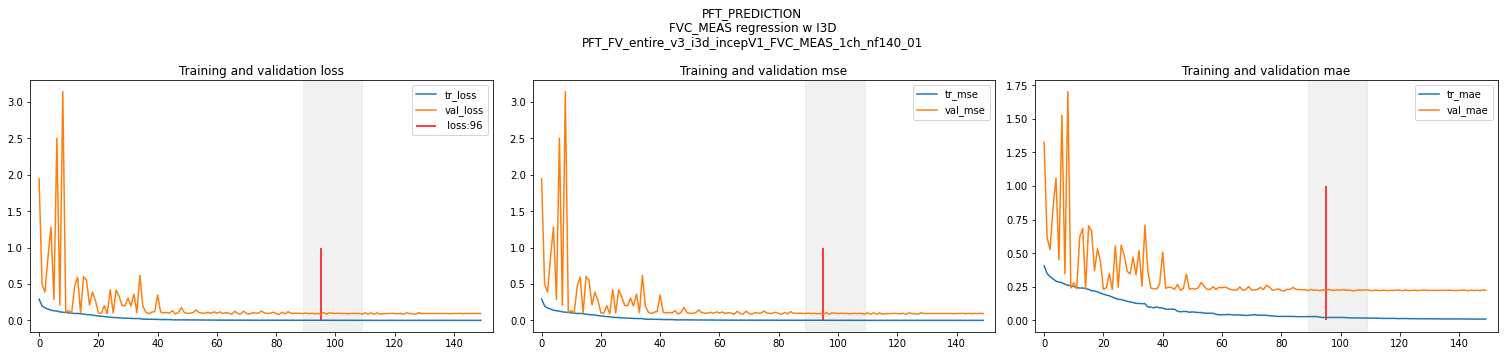

In [94]:
epochs = df_log.epoch


loss = df_log.loss
val_loss = df_log.val_loss

mse = df_log.mean_squared_error
val_mse =  df_log.val_mean_squared_error

mae = df_log.mean_absolute_error
val_mae =  df_log.val_mean_absolute_error

#-------------------------------------------------------------



f,a = plt.subplots( nrows = 1, ncols = 3,figsize = (21,5) )
f.suptitle(f"PFT_PREDICTION\n{col_y} regression w I3D\n{tr_num}")


# Plot training and validation loss per epoch
a[0].plot(epochs, loss, label = "tr_loss")
a[0].plot(epochs, val_loss, label = "val_loss")

a[0].vlines(x = val_loss_chosen-1, ymin = 0, ymax = 1, color = "red" , label = f" loss:{val_loss_chosen}" )
a[0].axvspan(idx_first_stage[0]-1,idx_first_stage[1]-1, alpha = 0.3, color = "lightgray")
a[0].legend()
a[0].set_title('Training and validation loss')

a[1].plot(epochs, mse, label = "tr_mse")
a[1].plot(epochs, val_mse, label = "val_mse")
a[1].axvspan(idx_first_stage[0]-1,idx_first_stage[1]-1, alpha = 0.3, color = "lightgray")
a[1].vlines(x = val_loss_chosen-1, ymin = 0, ymax = 1, color = "red" )

a[1].legend()
# a[1].set_ylim(0, 1)
a[1].set_title('Training and validation mse')


a[2].plot(epochs, mae, label = "tr_mae")
a[2].plot(epochs, val_mae, label = "val_mae")
a[2].axvspan(idx_first_stage[0]-1,idx_first_stage[1]-1, alpha = 0.3, color = "lightgray")
a[2].vlines(x = val_loss_chosen-1, ymin = 0, ymax = 1, color = "red" )

a[2].legend()
# a[2].set_ylim(0, 1)
a[2].set_title('Training and validation mae')

#-------
xlim_min = -3
xlim_max = len(df_log)+3

for i  in [0,1,2]:
    a[i].set_xlim(xlim_min, len(df_log)+3)
#--

plt.tight_layout()
plt.show()

In [95]:
print(val_loss_chosen)

96


In [ ]:
# list_idx =  [val_loss_chosen_1,val_loss_chosen_2, val_mae_chosen_1,  val_loss.idxmin(), val_mae.idxmin()]
# print(list_idx)


In [ ]:
#                     _examID = df_train.loc[_idx, "HE0108(R5253A)검사접수번호"]
#                     _y_idx = df_train.loc[_idx, "y_idx"]
#                     _filename = os.path.join(PATH_input, f"{_examID}.hdr" )

In [64]:
from scipy.stats import zscore

import re, random
def list_sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    def tryint(s):
        try:
            return int(s)
        except:
            return s
    def alphanum_key(s):
        """ Turn a string into a list of string and number chunks.
            "z23a" -> ["z", 23, "a"]
        """
        return [ tryint(c) for c in re.split('([0-9]+)', s) ]
    l.sort(key=alphanum_key)
    return l

#-------
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import tqdm
from datetime import datetime
now = datetime.now().strftime("%y%m%d")
#----

def model_prediction(_df, load_func, _idx, splitted_set, save_df = False):
    _idx = chosen_idx_of_weight

    y= [ ]
    score = [ ]
    totScore=[]
    test_true = []
    test_predictions=[] # 예측값
    test_predictions_value = []

    for _idx, _row in tqdm.tqdm(_df.iterrows()):
    #     print(_idx)

        _filename = _row["path_in_workspace"]


        img_test = load_func(_filename)
    #     print(model.predict(np.expand_dims(img_test, axis=0)))
        test_predictions.append(model.predict(np.expand_dims(img_test, axis=0)))

        test_predictions_value.append(model.predict(np.expand_dims(img_test, axis=0))[0][0])
        test_true.append(_row[col_y])
        
    col_y_pred = f"modelpredicted({col_y})_wt{chosen_idx_of_weight}"
    col_residual = f"residuals_wt{chosen_idx_of_weight}"
    col_resid_z = f"zscore_residuals_weight{chosen_idx_of_weight}"
    _df[col_y_pred] = test_predictions_value
    _df[col_residual] = _df[col_y_pred]  - _df[col_y] 
    _df[col_resid_z] = zscore(_df[col_residual])
    
    if save_df:
        save_path = os.path.join(PATH_trial,f"df_{splitted_set}_result_{tr_num}_weight_{chosen_idx_of_weight}_({now}).xlsx")
        _df.to_excel(save_path)
    return _df, col_y_pred, col_residual, col_resid_z
#--------
import scipy as sp
def get_residual_plot(Y_TRUE, Y_PRED):
    resid = Y_PRED- Y_TRUE
    plt.scatter(Y_TRUE, resid, marker = ".", linewidth = 1, color = "k")
#     plt.hlines( y = 0, xmin = 1, xmax = 7)
    plt.xlabel("TRUE")
    plt.ylabel("residual")
    plt.title(tr_num)
    plt.show()
    
    plt.scatter(Y_TRUE, resid, marker = ".", linewidth = 1, color = "k")
    plt.xlabel("TRUE")
    plt.ylabel("residual")
    plt.title(tr_num)
    plt.show()
    print(abs(resid).max(), abs(resid).mean(), resid.std(), abs(resid).median())
    
    plt.hist(resid, edgecolor ="k" , bins = 20)
    plt.title(tr_num)
    plt.show()
    
    sp.stats.probplot(resid, plot = plt)
    plt.axis("equal")
    plt.show()
    # skewness test
    
    
#---------
import numpy as np
from math import sqrt
from sklearn.metrics import r2_score, max_error, median_absolute_error
def get_RMSE(Y_TRUE, Y_PRED):
    mse = np.average((Y_PRED - Y_TRUE)**2)
    rmse = sqrt(mse)
    return rmse

def get_MAE(Y_TRUE, Y_PRED):
    mae = np.average(abs(Y_PRED - Y_TRUE))
    return mae

def get_max_error(Y_TRUE, Y_PRED):
    max_er = max_error(Y_PRED , Y_TRUE)
    return max_er



def get_evalutation_metrics(Y_TRUE, Y_PRED):
    print(tr_num, "\n", chosen_idx_of_weight)
    rmse = get_RMSE(Y_TRUE, Y_PRED)
    
    mae_value = get_MAE(Y_TRUE, Y_PRED)
    abs_max_error_value = get_max_error(Y_TRUE, Y_PRED)
    median_abs_error_value = median_absolute_error(Y_TRUE, Y_PRED)
    r2_scipy_value = r2_score(Y_TRUE, Y_PRED)
    
    correlation_matrix = np.corrcoef(Y_TRUE, Y_PRED)
    correlation_xy = correlation_matrix[0,1]
    r2_cal = correlation_xy**2
    
    resid = Y_PRED - Y_TRUE
    
    print("RMSE: ", rmse)
    print("MAE: ", mae_value)
    print("R2_scipy: ", r2_scipy_value)
    print("R2_cal:", r2_cal)
    
    print("\nmax resid: ", abs(resid).max())
    print("mean resid: ", abs(resid).mean())
    print("std resid: ", resid.std())
    print("median resid: ", abs(resid).median())
    
    return rmse, mae_value, r2_scipy_value, r2_cal, abs_max_error_value, median_abs_error_value


# =============================================================================
# # Bland Altman Plot by sex
# =============================================================================
def get_Bland_Altman_by_sex(target_df, col_measure1, col_measure2, check_criteria = 1.96, modified = False):
    import statsmodels.api as sm
    import numpy as np
    import matplotlib.pyplot as plt
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    target_measure_1 =col_measure1
    target_measure_2 = col_measure2

#     df_target =target_df.copy() 
    ax_ylim = (target_df[target_measure_1] -target_df[target_measure_2]).abs().max()
    ax_xlim_min = np.round(target_df[target_measure_1].min(), 2)
    ax_xlim_max = np.round(target_df[target_measure_1].max(), 2)
    if modified == False:
        #----------------------------------------------------------------
        f, ax = plt.subplots(1,3, figsize = (21,5))   
        f.suptitle("Bland-Altman Plot\n- First Visit 2018 - weak external validation set", fontsize = 20)






        for _i, (_sex, _color, _marker) in enumerate(zip(["F", "M"],colors, ["+", "x"])) :
            df_sub = target_df[target_df["sex"] == _sex]

            # version 1
        #     m1 =df_sub['FVC_MEAS ']
        #     m2 = df_sub['modelpredicted(FVC_MEAS )']
            # version 2
            m2 =df_sub[target_measure_1]
            m1 = df_sub[target_measure_2]    

            sm.graphics.mean_diff_plot(m1, m2, ax = ax[_i],
                                       sd_limit = check_criteria, 
                                    scatter_kwds = {"marker":_marker, 
                                                     "color":_color, 
                                                     "alpha":0.7})
            ax[_i].set_xlabel(f"average({target_measure_1}, {target_measure_1} model estimation)", fontsize = 12)
            ax[_i].set_title(_sex, fontsize = 15)
            ax[_i].set_ylim(-ax_ylim, ax_ylim)
            ax[_i].set_xlim(ax_xlim_min, ax_xlim_max)




            #----------------------------------------------------------------------
            means = np.mean([m1, m2], axis=0)
            diffs = m1 - m2
            mean_diff = np.mean(diffs)
            std_diff = np.std(diffs, axis=0)

            ax[2].scatter(means, diffs, 
                         marker = _marker,
                         color = _color, 
                         alpha = 0.7, label = _sex)
            ax[2].hlines(mean_diff,xmin =ax_xlim_min, xmax = ax_xlim_max,
                        color = _color, 
                        linestyle = "--", linewidth = 1)
            ax[2].hlines(mean_diff + check_criteria *std_diff,xmin =ax_xlim_min, xmax = ax_xlim_max,
                        color = _color,
                         linestyle = "--", linewidth = 1)
            ax[2].hlines(mean_diff - check_criteria *std_diff,xmin =ax_xlim_min, xmax = ax_xlim_max,
                        color = _color,
                        linestyle = "--", linewidth = 1)

        ax[1].set_ylabel("")  
        ax[2].set_ylabel("")

        ax[2].tick_params(labelsize = 13)
        ax[2].legend()
        ax[2].set_xlabel(f"average({target_measure_1}, {target_measure_1} model estimation)", fontsize = 12)
        ax[2].set_ylim(-ax_ylim,ax_ylim)
        ax[2].set_xlim(ax_xlim_min, ax_xlim_max)

        f.tight_layout()   
    elif modified == True:
        f, ax = plt.subplots(1,3, figsize = (21,5))   
        f.suptitle("Modified Bland-Altman Plot(Redidual)\n- First Visit 2018 - weak external validation set - ", fontsize = 20)


        for _i, (_sex, _color, _marker) in enumerate(zip(["F", "M"],colors, ["+", "x"])) :
            df_sub = target_df[target_df["sex"] == _sex]
            x =df_sub[target_measure_1]
            m2 =df_sub[target_measure_1]
            m1 = df_sub[target_measure_2]    
                  
            diffs = m1 - m2
            mean_diff = np.mean(diffs)
            std_diff = np.std(diffs, axis=0)      
                  
                  
            ax[_i].scatter(x, diffs , marker = _marker, color = _color, alpha = 0.7, s = 20)


            ax[_i].hlines(y =mean_diff ,
                          xmin = ax_xlim_min ,
                          xmax = ax_xlim_max, 
                          linestyle = "solid",
                          color = _color,
                          linewidth = 1)

            ax[_i].hlines(y = mean_diff + check_criteria * std_diff ,
                          xmin = ax_xlim_min ,
                          xmax = ax_xlim_max, 
                          linestyle = "--",
                          color = _color,
                          linewidth = 1)
            ax[_i].hlines(y = mean_diff - check_criteria * std_diff ,
                          xmin = ax_xlim_min ,
                          xmax = ax_xlim_max, 
                          linestyle = "--",
                          color = _color,
                          linewidth = 1)
            
            # Annotate mean line with mean difference.
            ax[_i].annotate('mean diff:\n{}'.format(np.round(mean_diff, 2)),
                        xy=(0.99, 0.5),
                        horizontalalignment='right',
                        verticalalignment='center',
                        fontsize=14,
                        xycoords='axes fraction')
            upper = mean_diff + check_criteria * std_diff
            lower = mean_diff - check_criteria * std_diff
            ax[_i].annotate('-SD{}: {}'.format(check_criteria, np.round(lower, 2)),
                    xy=(0.99, 0.07),
                    horizontalalignment='right',
                    verticalalignment='bottom',
                    fontsize=14,
                    xycoords='axes fraction')
            ax[_i].annotate('+SD{}: {}'.format(check_criteria, np.round(upper, 2)),
                    xy=(0.99, 0.92),
                    horizontalalignment='right',
                    fontsize=14,
                    xycoords='axes fraction')




            ax[_i].set_xlabel(target_measure_1, fontsize = 12)
            ax[_i].set_title(_sex, fontsize = 15)
            ax[_i].set_ylim(-ax_ylim, ax_ylim)
            ax[_i].set_xlim(ax_xlim_min, ax_xlim_max)

            ax[2].scatter(x, diffs , marker = _marker, color = _color, alpha = 0.7, 
                          s = 20,
                         label = _sex)
            ax[2].hlines(y =mean_diff ,
                          xmin = ax_xlim_min ,
                          xmax = ax_xlim_max, 
                          linestyle = "solid",
                          color = _color,
                          linewidth = 1)

            ax[2].hlines(y =  mean_diff + check_criteria * std_diff,
                          xmin = ax_xlim_min ,
                          xmax = ax_xlim_max, 
                          linestyle = "--",
                          color = _color,
                          linewidth = 1)
            ax[2].hlines(y =  mean_diff - check_criteria * std_diff ,
                          xmin = ax_xlim_min ,
                          xmax = ax_xlim_max, 
                          linestyle = "--",
                          color = _color,
                          linewidth = 1)

            ax[_i].tick_params(labelsize = 13)
        ax[2].tick_params(labelsize = 13) 
        ax[2].set_xlabel(target_measure_1, fontsize = 12)
        ax[2].set_ylim(-ax_ylim, ax_ylim)
        ax[2].set_xlim(ax_xlim_min, ax_xlim_max)
        ax[2].legend()

        ax[0].set_ylabel("Difference(estimation  - measured)", fontsize = 15)
        ax[1].set_ylabel("")
        ax[2].set_ylabel("")
        f.tight_layout()
        
    return f, ax


In [65]:
df_test_shuffled= df_test.sample(frac =1, random_state = 100).reset_index(drop = True)

In [66]:
os.listdir(PATH_trial)

['weights',
 'tensorboard_log',
 'PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01_metric_testset.txt',
 'PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01_metric_trainset.txt',
 'df_train_result_PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01_weight_96_(210614).xlsx',
 'df_test_result_PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01_weight_96_(210614).xlsx',
 'scatter_sq_PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01_w96_train.png',
 'scatter_sq_PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01_w96_test.png']

In [67]:
print(tr_num)

PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01


In [70]:
list_idx = [val_loss_chosen]
print(list_idx)

[144]


  0%|          | 0/1 [00:00<?, ?it/s]

[144]



0it [00:00, ?it/s]

/workspace/nas100_vol2/projects/04_PFT/PFT_FV_entire_regression_with_preprocessing_v3/PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01/weights/train_weights_epoch_144.h5



1it [00:03,  3.29s/it]
2it [00:03,  2.38s/it]
3it [00:03,  1.75s/it]
4it [00:04,  1.30s/it]
5it [00:04,  1.01it/s]
6it [00:04,  1.31it/s]
7it [00:04,  1.62it/s]
8it [00:05,  1.96it/s]
9it [00:05,  2.31it/s]
10it [00:05,  2.64it/s]
11it [00:05,  2.94it/s]
12it [00:06,  3.18it/s]
13it [00:06,  3.38it/s]
14it [00:06,  3.53it/s]
15it [00:06,  3.64it/s]
16it [00:07,  3.71it/s]
17it [00:07,  3.80it/s]
18it [00:07,  3.87it/s]
19it [00:07,  3.86it/s]
20it [00:08,  3.87it/s]
21it [00:08,  3.88it/s]
22it [00:08,  3.90it/s]
23it [00:08,  3.88it/s]
24it [00:09,  3.90it/s]
25it [00:09,  3.91it/s]
26it [00:09,  3.91it/s]
27it [00:09,  3.86it/s]
28it [00:10,  3.91it/s]
29it [00:10,  3.92it/s]
30it [00:10,  3.94it/s]
31it [00:10,  3.94it/s]
32it [00:11,  3.92it/s]
33it [00:11,  3.92it/s]
34it [00:11,  3.91it/s]
35it [00:12,  3.82it/s]
36it [00:12,  3.86it/s]
37it [00:12,  3.89it/s]
38it [00:12,  3.87it/s]
39it [00:13,  3.88it/s]
40it [00:13,  3.87it/s]
41it [00:13,  3.90it/s]
42it [00:13,  3.91it/s]


 num of 'M' subjects:  6444
 num of 'F' subjects:  2954


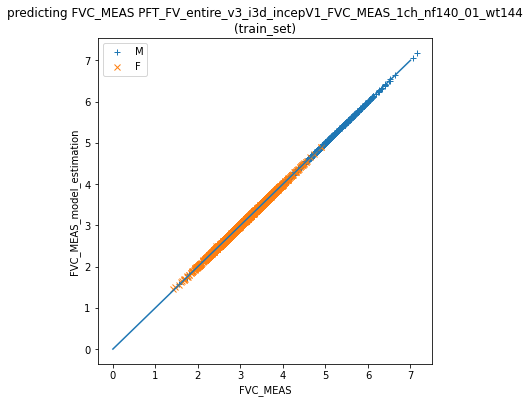

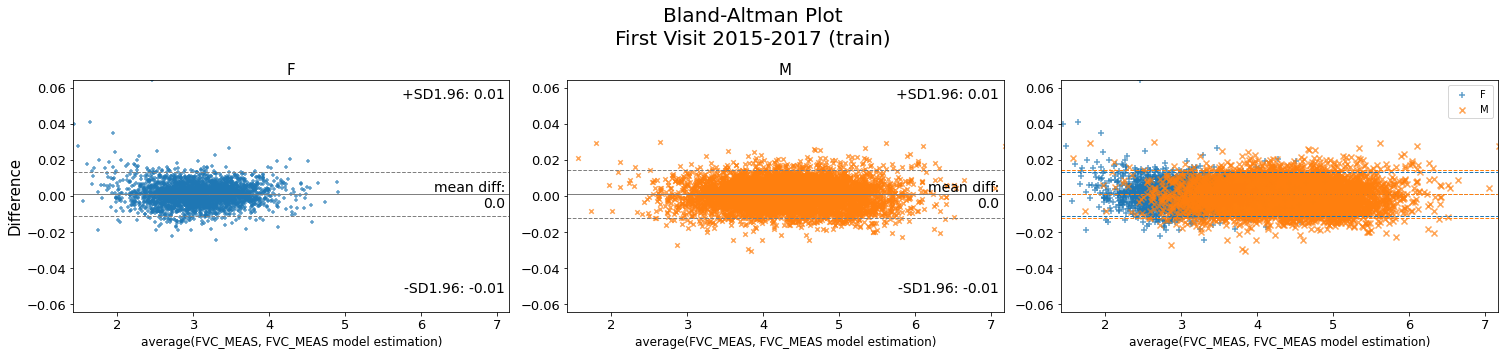

 num of 'M' subjects:  1867
 num of 'F' subjects:  820


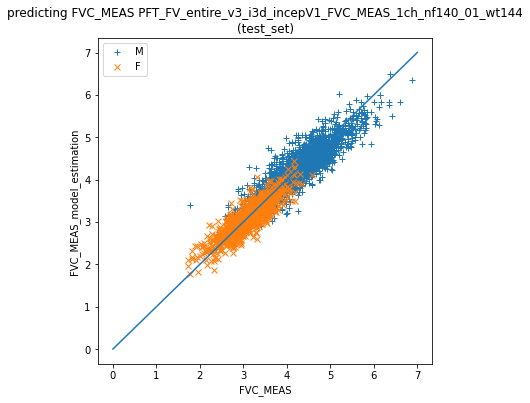

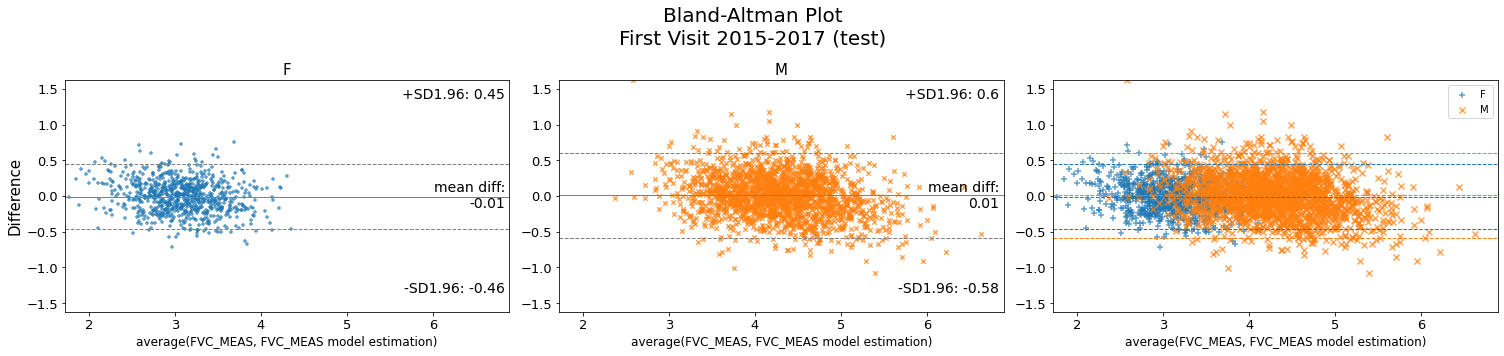

100%|██████████| 1/1 [1:01:33<00:00, 3693.13s/it]

PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01 
 144
RMSE:  0.28258227342351866
MAE:  0.21983948431806488
R2_scipy:  0.8776528857434127
R2_cal: 0.8778722575972704

max resid:  1.6213755416870117
mean resid:  0.21983948431806488
std resid:  0.28260814816818874
median resid:  0.17715711593627947
144,0.28258227342351866, 0.21983948431806488,0.8776528857434127,0.8778722575972704,1.6213755416870117,0.17715711593627947

PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01 
 144
RMSE:  0.006714723952227618
MAE:  0.005205150101128528
R2_scipy:  0.9999347074998366
R2_cal: 0.9999360036964042

max resid:  0.06410939216613754
mean resid:  0.005205150101128528
std resid:  0.006648227252003794
median resid:  0.004245352745055886
144,0.006714723952227618, 0.005205150101128528,0.9999347074998366,0.9999360036964042,0.06410939216613754,0.004245352745055886



In [71]:
# targetset = "test"
df_target = df_test_shuffled.copy()


#------------
list_unique = sorted(np.unique(list_idx).tolist())
print(list_unique)
#--------------
save_test = open(os.path.join(PATH_trial, f"{tr_num}_metric_testset.txt"), 'w')
save_train = open(os.path.join(PATH_trial, f"{tr_num}_metric_trainset.txt"), 'w')
# save_test.close()
label = "index,RMSE,MAE,R2_scipy,R2_cal,max_error,median_abs_error\n"
save_test.write(label)
save_test.close()

# save_train.close()
save_train.write(label)
save_train.close()



for chosen_idx_of_weight in tqdm.tqdm(list_unique):
    
    weightpath=os.path.join(os.path.join(PATH_trial,'weights','train_weights_epoch_{}.h5').format(str(chosen_idx_of_weight).zfill(3)))
    model.load_weights(weightpath)
    print(weightpath)

    df_train, col_y_pred, col_residual, col_resid_z = model_prediction(df_train, load_image, chosen_idx_of_weight,"train", save_df = True)
    df_target, col_y_pred, col_residual, col_resid_z = model_prediction(df_target, load_image, chosen_idx_of_weight,"test", save_df = True)
    
    

    for df_to_plot, _set in zip([df_train, df_target], ["train", "test"]):
        #------- scatter plot ------------------------------
        plt.figure(figsize = (6,6))
        for _sex, _marker in zip(df_to_plot["sex"].value_counts().index.values, ["+", "x"]):

            df_tmp = df_to_plot[df_to_plot["sex"] == _sex]
            print(f" num of '{_sex}' subjects: ", len(df_tmp))
    #         col_y_pred = f"modelpredicted({col_y})_wt{chosen_idx_of_weight}"
    #         col_residual = f"residuals_wt{chosen_idx_of_weight}"
    #         col_resid_z = f"zscore_residuals_weight{chosen_idx_of_weight}"

            _y_true = df_tmp[col_y]
            _y_pred = df_tmp[col_y_pred]
            plt.scatter(_y_true, _y_pred , marker =_marker, linewidth = 1, label = _sex)
        plt.plot([0,7], [0,7])
        plt.legend()
        plt.title(f"predicting {col_y} {tr_num}_wt{chosen_idx_of_weight}\n({_set}_set)")
        plt.savefig(os.path.join(PATH_trial, f"scatter_sq_{tr_num}_w{chosen_idx_of_weight}_{_set}.png"))

        plt.xlabel(col_y)
        plt.ylabel(f'{col_y}_model_estimation')
        plt.show()    
        
        #-----------------bland altman plot
        
        fig, ax = get_Bland_Altman_by_sex(df_to_plot, col_y, col_y_pred, check_criteria = 1.96, modified = False)
        fig.suptitle(f"Bland-Altman Plot\nFirst Visit 2015-2017 ({_set})", position = (0.52, 1.10), fontsize = 20)
        plt.show()
        
        

    #--------------------------------------testset
    y_true = df_target[col_y]
    y_pred = df_target[col_y_pred]

#     get_residual_plot(y_true, y_pred)
    rmse, mae, r2_scipy, r2_cal,max_error_value, median_abs_error = get_evalutation_metrics(y_true, y_pred)
    
    #-------- save
    save_test = open(os.path.join(PATH_trial, f"{tr_num}_metric_testset.txt"), 'a')
    data = f"{chosen_idx_of_weight},{rmse}, {mae},{r2_scipy},{r2_cal},{max_error_value},{median_abs_error}\n"
    save_test.write(data)
    print(data)
    
    save_test.close()
    
    #-------- save-------------------trainset
    
    y_true = df_train[col_y]
    y_pred = df_train[col_y_pred]

#     get_residual_plot(y_true, y_pred)
    rmse, mae, r2_scipy, r2_cal,max_error_value, median_abs_error = get_evalutation_metrics(y_true, y_pred)
    
    save_train = open(os.path.join(PATH_trial, f"{tr_num}_metric_trainset.txt"), 'a')
    data = f"{chosen_idx_of_weight},{rmse}, {mae},{r2_scipy},{r2_cal},{max_error_value},{median_abs_error}\n"
    save_train.write(data)
    print(data)
    
    save_train.close()
    

In [76]:
from scipy.stats import zscore
import matplotlib.pyplot as plt

import re, random
def list_sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    def tryint(s):
        try:
            return int(s)
        except:
            return s
    def alphanum_key(s):
        """ Turn a string into a list of string and number chunks.
            "z23a" -> ["z", 23, "a"]
        """
        return [ tryint(c) for c in re.split('([0-9]+)', s) ]
    l.sort(key=alphanum_key)
    return l


#--------
import scipy as sp
def get_residual_plot(Y_TRUE, Y_PRED):
    resid = Y_PRED- Y_TRUE
    plt.scatter(Y_TRUE, resid, marker = ".", linewidth = 1, color = "k")
#     plt.hlines( y = 0, xmin = 1, xmax = 7)
    plt.xlabel("TRUE")
    plt.ylabel("residual")
    plt.title(tr_num)
    plt.show()
    
    plt.scatter(Y_TRUE, resid, marker = ".", linewidth = 1, color = "k")
    plt.xlabel("TRUE")
    plt.ylabel("residual")
    plt.title(tr_num)
    plt.show()
    print(abs(resid).max(), abs(resid).mean(), resid.std(), abs(resid).median())
    
    plt.hist(resid, edgecolor ="k" , bins = 20)
    plt.title(tr_num)
    plt.show()
    
    sp.stats.probplot(resid, plot = plt)
    plt.axis("equal")
    plt.show()
    # skewness test
    
    
#---------
import numpy as np
from math import sqrt
from sklearn.metrics import r2_score, max_error, median_absolute_error
def get_RMSE(Y_TRUE, Y_PRED):
    mse = np.average((Y_PRED - Y_TRUE)**2)
    rmse = sqrt(mse)
    return rmse

def get_MAE(Y_TRUE, Y_PRED):
    mae = np.average(abs(Y_PRED - Y_TRUE))
    return mae

def get_max_error(Y_TRUE, Y_PRED):
    max_er = max_error(Y_PRED , Y_TRUE)
    return max_er
def get_uncentered_R_squared(Y_TRUE, Y_PRED):
    SS_tot_uncentered = (Y_PRED**2).sum()
    SS_res = ((Y_PRED - Y_TRUE)**2).sum()

    R_squared_uncentered = 1- SS_res/SS_tot_uncentered
    return R_squared_uncentered

def get_CCC(Y_TRUE, Y_PRED):

    x_bar = np.mean(Y_TRUE)
    y_bar = np.mean(Y_PRED)

    var_x = ((Y_TRUE - x_bar)**2).sum() / len(Y_TRUE)
    var_y = ((Y_PRED - y_bar)**2).sum() / len(Y_PRED)

    covar = ((Y_TRUE - x_bar)*(Y_PRED - y_bar)).sum()/ len(Y_TRUE)

    rho_c= (2 * covar) / (var_x + var_y + (x_bar - y_bar)**2)
    
    return rho_c



def get_evaluation_metrics(Y_TRUE, Y_PRED):
#     print(tr_num, "\n", _target_col)
    rmse_value = get_RMSE(Y_TRUE, Y_PRED)
    
    mae_value = get_MAE(Y_TRUE, Y_PRED)
    abs_max_error_value = get_max_error(Y_TRUE, Y_PRED)
    median_abs_error_value = median_absolute_error(Y_TRUE, Y_PRED)
    
    r2_scipy_value = r2_score(Y_TRUE, Y_PRED)
    
#     correlation_matrix = np.corrcoef(Y_TRUE, Y_PRED)
#     correlation_xy = correlation_matrix[0,1]
#     r2_inverse = correlation_xy**2
    r2_inverse_value = r2_score( Y_PRED, Y_TRUE)
    resid = Y_PRED - Y_TRUE
    r2_uncentered = get_uncentered_R_squared( Y_TRUE, Y_PRED)
    Lin_concor_value = get_CCC(Y_TRUE, Y_PRED)
    
    print("RMSE: ", rmse_value)
    print("MAE: ", mae_value)
    print("R2_scipy: ", r2_scipy_value)
    print("R2_scipy_inverse:", r2_inverse_value)
    print("R2_uncentered: ", r2_uncentered)
    print("Lin Concordance correlation coefficient: ", Lin_concor_value)
    
    print("\nmax resid: ", abs(resid).max())
    print("mean resid: ", abs(resid).mean())
    print("std resid: ", resid.std())
    print("median resid: ", abs(resid).median())
    
    return rmse_value, mae_value, abs_max_error_value, median_abs_error_value, Lin_concor_value, r2_scipy_value, r2_inverse_value


# def get_evalutation_metrics(Y_TRUE, Y_PRED):
# #     print(tr_num, "\n", _target_col)
#     rmse = get_RMSE(Y_TRUE, Y_PRED)
    
#     mae_value = get_MAE(Y_TRUE, Y_PRED)
#     abs_max_error_value = get_max_error(Y_TRUE, Y_PRED)
#     median_abs_error_value = median_absolute_error(Y_TRUE, Y_PRED)
#     r2_scipy_value = r2_score(Y_TRUE, Y_PRED)
    
#     correlation_matrix = np.corrcoef(Y_TRUE, Y_PRED)
#     correlation_xy = correlation_matrix[0,1]
#     r2_cal = correlation_xy**2
    
#     resid = Y_PRED - Y_TRUE
    
#     print("RMSE: ", rmse)
#     print("MAE: ", mae_value)
#     print("R2_scipy: ", r2_scipy_value)
#     print("R2_cal:", r2_cal)
    
#     print("\nmax resid: ", abs(resid).max())
#     print("mean resid: ", abs(resid).mean())
#     print("std resid: ", resid.std())
#     print("median resid: ", abs(resid).median())
    
#     return rmse, mae_value, r2_scipy_value, r2_cal, abs_max_error_value, median_abs_error_value


# =============================================================================
# # Bland Altman Plot by sex
# =============================================================================
def get_Bland_Altman_by_sex(target_df, col_measure1, col_measure2, check_criteria = 1.96, modified = False):
    import statsmodels.api as sm
    import numpy as np
    import matplotlib.pyplot as plt
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']

    target_measure_1 =col_measure1
    target_measure_2 = col_measure2

#     df_target =target_df.copy() 
    ax_ylim = (target_df[target_measure_1] -target_df[target_measure_2]).abs().max()
    ax_xlim_min = np.round(target_df[target_measure_1].min(), 2)
    ax_xlim_max = np.round(target_df[target_measure_1].max(), 2)
    if modified == False:
        #----------------------------------------------------------------
        f, ax = plt.subplots(1,3, figsize = (21,5))   
        f.suptitle("Bland-Altman Plot\n- First Visit 2018 - weak external validation set", fontsize = 20)






        for _i, (_sex, _color, _marker) in enumerate(zip(["F", "M"],colors, ["+", "x"])) :
            df_sub = target_df[target_df["sex"] == _sex]

            # version 1
        #     m1 =df_sub['FVC_MEAS ']
        #     m2 = df_sub['modelpredicted(FVC_MEAS )']
            # version 2
            m2 =df_sub[target_measure_1]
            m1 = df_sub[target_measure_2]    

            sm.graphics.mean_diff_plot(m1, m2, ax = ax[_i],
                                       sd_limit = check_criteria, 
                                    scatter_kwds = {"marker":_marker, 
                                                     "color":_color, 
                                                     "alpha":0.7})
            ax[_i].set_xlabel(f"average({target_measure_1}, {target_measure_1} model estimation)", fontsize = 12)
            ax[_i].set_title(_sex, fontsize = 15)
            ax[_i].set_ylim(-ax_ylim, ax_ylim)
            ax[_i].set_xlim(ax_xlim_min, ax_xlim_max)




            #----------------------------------------------------------------------
            means = np.mean([m1, m2], axis=0)
            diffs = m1 - m2
            mean_diff = np.mean(diffs)
            std_diff = np.std(diffs, axis=0)

            ax[2].scatter(means, diffs, 
                         marker = _marker,
                         color = _color, 
                         alpha = 0.7, label = _sex)
            ax[2].hlines(mean_diff,xmin =ax_xlim_min, xmax = ax_xlim_max,
                        color = _color, 
                        linestyle = "--", linewidth = 1)
            ax[2].hlines(mean_diff + check_criteria *std_diff,xmin =ax_xlim_min, xmax = ax_xlim_max,
                        color = _color,
                         linestyle = "--", linewidth = 1)
            ax[2].hlines(mean_diff - check_criteria *std_diff,xmin =ax_xlim_min, xmax = ax_xlim_max,
                        color = _color,
                        linestyle = "--", linewidth = 1)

        ax[1].set_ylabel("")  
        ax[2].set_ylabel("")

        ax[2].tick_params(labelsize = 13)
        ax[2].legend()
        ax[2].set_xlabel(f"average({target_measure_1}, {target_measure_1} model estimation)", fontsize = 12)
        ax[2].set_ylim(-ax_ylim,ax_ylim)
        ax[2].set_xlim(ax_xlim_min, ax_xlim_max)

        f.tight_layout()   
    elif modified == True:
        f, ax = plt.subplots(1,3, figsize = (21,5))   
#         f.suptitle("Modified Bland-Altman Plot(Redidual)\n- First Visit 2018 - weak external validation set - ", fontsize = 20)


        for _i, (_sex, _color, _marker) in enumerate(zip(["F", "M"],colors, ["+", "x"])) :
            df_sub = target_df[target_df["성별"] == _sex]
            x =df_sub[target_measure_1]
            m2 =df_sub[target_measure_1]
            m1 = df_sub[target_measure_2]    
                  
            diffs = m1 - m2
            mean_diff = np.mean(diffs)
            std_diff = np.std(diffs, axis=0)      
                  
                  
            ax[_i].scatter(x, diffs , marker = _marker, color = _color, alpha = 0.7, s = 20)


            ax[_i].hlines(y =mean_diff ,
                          xmin = ax_xlim_min ,
                          xmax = ax_xlim_max, 
                          linestyle = "solid",
                          color = _color,
                          linewidth = 1)

            ax[_i].hlines(y = mean_diff + check_criteria * std_diff ,
                          xmin = ax_xlim_min ,
                          xmax = ax_xlim_max, 
                          linestyle = "--",
                          color = _color,
                          linewidth = 1)
            ax[_i].hlines(y = mean_diff - check_criteria * std_diff ,
                          xmin = ax_xlim_min ,
                          xmax = ax_xlim_max, 
                          linestyle = "--",
                          color = _color,
                          linewidth = 1)
            
            # Annotate mean line with mean difference.
            ax[_i].annotate('mean diff:\n{}'.format(np.round(mean_diff, 2)),
                        xy=(0.99, 0.5),
                        horizontalalignment='right',
                        verticalalignment='center',
                        fontsize=14,
                        xycoords='axes fraction')
            upper = mean_diff + check_criteria * std_diff
            lower = mean_diff - check_criteria * std_diff
            ax[_i].annotate('-SD{}: {}'.format(check_criteria, np.round(lower, 2)),
                    xy=(0.99, 0.07),
                    horizontalalignment='right',
                    verticalalignment='bottom',
                    fontsize=14,
                    xycoords='axes fraction')
            ax[_i].annotate('+SD{}: {}'.format(check_criteria, np.round(upper, 2)),
                    xy=(0.99, 0.92),
                    horizontalalignment='right',
                    fontsize=14,
                    xycoords='axes fraction')




            ax[_i].set_xlabel(target_measure_1, fontsize = 12)
            ax[_i].set_title(_sex, fontsize = 15)
            ax[_i].set_ylim(-ax_ylim, ax_ylim)
            ax[_i].set_xlim(ax_xlim_min, ax_xlim_max)

            ax[2].scatter(x, diffs , marker = _marker, color = _color, alpha = 0.7, 
                          s = 20,
                         label = _sex)
            ax[2].hlines(y =mean_diff ,
                          xmin = ax_xlim_min ,
                          xmax = ax_xlim_max, 
                          linestyle = "solid",
                          color = _color,
                          linewidth = 1)

            ax[2].hlines(y =  mean_diff + check_criteria * std_diff,
                          xmin = ax_xlim_min ,
                          xmax = ax_xlim_max, 
                          linestyle = "--",
                          color = _color,
                          linewidth = 1)
            ax[2].hlines(y =  mean_diff - check_criteria * std_diff ,
                          xmin = ax_xlim_min ,
                          xmax = ax_xlim_max, 
                          linestyle = "--",
                          color = _color,
                          linewidth = 1)

            ax[_i].tick_params(labelsize = 13)
        ax[2].tick_params(labelsize = 13) 
        ax[2].set_xlabel(target_measure_1, fontsize = 12)
        ax[2].set_ylim(-ax_ylim, ax_ylim)
        ax[2].set_xlim(ax_xlim_min, ax_xlim_max)
        ax[2].legend()

        ax[0].set_ylabel("Difference(estimation  - measured)", fontsize = 15)
        ax[1].set_ylabel("")
        ax[2].set_ylabel("")
        f.tight_layout()
        
    return f, ax
def get_Bland_Altman_by_sex_v2(target_df, col_measure1, col_measure2, check_criteria = 1.96, modified = False):
    import statsmodels.api as sm
    import numpy as np
    import matplotlib.pyplot as plt
    target_measure_1 =col_measure1
    target_measure_2 = col_measure2
    target_str = target_measure_1.split("_")[0]

    df_target =target_df.copy() 
    ax_ylim = (df_target[target_measure_1] -df_target[target_measure_2]).abs().max()
    ax_xlim_min = np.round(df_target[target_measure_1].min(), 2)
    ax_xlim_max = np.round(df_target[target_measure_1].max(), 2)
#----------------------
    M2_total = df_target[target_measure_1]
    M1_total = df_target[target_measure_2]
    
    diffs_total = M1_total - M2_total 
    mean_diff_total = np.mean(diffs_total)
    std_diff_total = np.std(diffs_total, axis = 0)
    upper_total = mean_diff_total + check_criteria * std_diff_total
    lower_total = mean_diff_total - check_criteria * std_diff_total
    print(mean_diff_total,std_diff_total,upper_total  , lower_total)
#-----------------
    if modified == False:
        #----------------------------------------------------------------
        f, ax = plt.subplots(1,3, figsize = (21,5))   
#         f.suptitle("Bland-Altman Plot\n- First Visit 2018 - weak external validation set", fontsize = 20)


        for _i, (_sex, _color, _marker) in enumerate(zip(["F", "M"],colors, ["+", "x"])) :
            df_sub = target_df[target_df["성별"] == _sex]
            if _sex == "F":
                ax_title = "Female"
            else:
                ax_title = "Male"
            # version 1
        #     m1 =df_sub['FVC_MEAS ']
        #     m2 = df_sub['modelpredicted(FVC_MEAS )']
            # version 2
            m2 =df_sub[target_measure_1]
            m1 = df_sub[target_measure_2]    

            sm.graphics.mean_diff_plot(m1, m2, ax = ax[_i],
                                       sd_limit = check_criteria, 
                                    scatter_kwds = {"marker":_marker, 
                                                     "color":_color, 
                                                     "alpha":0.7})
            ax[_i].set_xlabel(f"Mean {target_str} (L)\n(actual + predicted)/2", fontsize = 13)
            ax[_i].set_title(ax_title, fontsize = 15)
            ax[_i].set_ylim(-ax_ylim, ax_ylim)
            ax[_i].set_xlim(ax_xlim_min, ax_xlim_max)




            #----------------------------------------------------------------------
            means = np.mean([m1, m2], axis=0)
            diffs = m1 - m2
            mean_diff = np.mean(diffs)
            std_diff = np.std(diffs, axis=0)

            ax[2].scatter(means, diffs, 
                         marker = _marker,
                         color = _color, 
                         alpha = 0.7, label = _sex)
            

        # draw line
        ax[2].hlines(mean_diff_total,xmin =ax_xlim_min, xmax = ax_xlim_max,
                    color = "k", 
                    linestyle = "--", linewidth = 1)
        ax[2].hlines(mean_diff_total + check_criteria *std_diff_total,xmin =ax_xlim_min, xmax = ax_xlim_max,
                    color = "k",
                     linestyle = "--", linewidth = 1)
        ax[2].hlines(mean_diff_total - check_criteria *std_diff_total,xmin =ax_xlim_min, xmax = ax_xlim_max,
                    color = "k",
                    linestyle = "--", linewidth = 1)
        
        # anootate 
        ax[2].annotate('mean diff:\n{}'.format(np.round(mean_diff_total, 2)),
                    xy=(0.99, 0.5),
                    horizontalalignment='right',
                    verticalalignment='center',
                    fontsize=14,
                    xycoords='axes fraction')

        ax[2].annotate('-SD{}: {}'.format(check_criteria, np.round(lower_total, 2)),
                xy=(0.99, 0.07),
                horizontalalignment='right',
                verticalalignment='bottom',
                fontsize=14,
                xycoords='axes fraction')
        ax[2].annotate('+SD{}: {}'.format(check_criteria, np.round(upper_total, 2)),
                xy=(0.99, 0.92),
                horizontalalignment='right',
                fontsize=14,
                xycoords='axes fraction')

        
        
        

        ax[1].set_ylabel("")  
        ax[2].set_ylabel("")
        ax[0].set_ylabel("Differences\n(predicted - actual)")

        ax[2].tick_params(labelsize = 13)
        ax[2].legend(loc = "upper left")
        ax[2].set_xlabel(f"Mean {target_str} (L)\n(actual + predicted)/2", fontsize = 13)
        ax[2].set_ylim(-ax_ylim,ax_ylim)
        ax[2].set_xlim(ax_xlim_min, ax_xlim_max)

        f.tight_layout()   
    elif modified == True:
        f, ax = plt.subplots(1,3, figsize = (21,5))   
#         f.suptitle("Modified Bland-Altman Plot(Redidual)\n- First Visit 2018 - weak external validation set - ", fontsize = 20)


        for _i, (_sex, _color, _marker) in enumerate(zip(["F", "M"],colors, ["+", "x"])) :
            df_sub = df_target[df_target["성별"] == _sex]
            x =df_sub[target_measure_1]
            m2 =df_sub[target_measure_1]
            m1 = df_sub[target_measure_2]    
                  
            diffs = m1 - m2
            mean_diff = np.mean(diffs)
            std_diff = np.std(diffs, axis=0)      
             
                  
            ax[_i].scatter(x, diffs , marker = _marker, color = _color, alpha = 0.7, s = 20)


            ax[_i].hlines(y =mean_diff ,
                          xmin = ax_xlim_min ,
                          xmax = ax_xlim_max, 
                          linestyle = "solid",
                          color = _color,
                          linewidth = 1)

            ax[_i].hlines(y = mean_diff + check_criteria * std_diff ,
                          xmin = ax_xlim_min ,
                          xmax = ax_xlim_max, 
                          linestyle = "--",
                          color = _color,
                          linewidth = 1)
            ax[_i].hlines(y = mean_diff - check_criteria * std_diff ,
                          xmin = ax_xlim_min ,
                          xmax = ax_xlim_max, 
                          linestyle = "--",
                          color = _color,
                          linewidth = 1)
            
            # Annotate mean line with mean difference.
            ax[_i].annotate('mean diff:\n{}'.format(np.round(mean_diff, 2)),
                        xy=(0.99, 0.5),
                        horizontalalignment='right',
                        verticalalignment='center',
                        fontsize=14,
                        xycoords='axes fraction')
            upper = mean_diff + check_criteria * std_diff
            lower = mean_diff - check_criteria * std_diff
            ax[_i].annotate('-SD{}: {}'.format(check_criteria, np.round(lower, 2)),
                    xy=(0.99, 0.07),
                    horizontalalignment='right',
                    verticalalignment='bottom',
                    fontsize=14,
                    xycoords='axes fraction')
            ax[_i].annotate('+SD{}: {}'.format(check_criteria, np.round(upper, 2)),
                    xy=(0.99, 0.92),
                    horizontalalignment='right',
                    fontsize=14,
                    xycoords='axes fraction')




            ax[_i].set_xlabel(target_measure_1, fontsize = 12)
            ax[_i].set_title(_sex, fontsize = 15)
            ax[_i].set_ylim(-ax_ylim, ax_ylim)
            ax[_i].set_xlim(ax_xlim_min, ax_xlim_max)
            ax[_i].tick_params(labelsize = 13)


        ax[2].hlines(mean_diff_total,xmin =ax_xlim_min, xmax = ax_xlim_max,
                    color = "k", 
                    linestyle = "--", linewidth = 1)
        ax[2].hlines(mean_diff_total + check_critiera *std_diff_total,xmin =ax_xlim_min, xmax = ax_xlim_max,
                    color = "k",
                     linestyle = "--", linewidth = 1)
        ax[2].hlines(mean_diff_total - check_critiera *std_diff_total,xmin =ax_xlim_min, xmax = ax_xlim_max,
                    color = "k",
                    linestyle = "--", linewidth = 1)
        
        # anootate 
        ax[2].annotate('mean diff:\n{}'.format(np.round(mean_diff_total, 2)),
                    xy=(0.99, 0.5),
                    horizontalalignment='right',
                    verticalalignment='center',
                    fontsize=14,
                    xycoords='axes fraction')
        ax[2].annotate('-SD{}: {}'.format(check_criteria, np.round(lower_total, 2)),
                xy=(0.99, 0.07),
                horizontalalignment='right',
                verticalalignment='bottom',
                fontsize=14,
                xycoords='axes fraction')
        ax[2].annotate('+SD{}: {}'.format(check_criteria, np.round(upper_total, 2)),
                xy=(0.99, 0.92),
                horizontalalignment='right',
                fontsize=14,
                xycoords='axes fraction')


        ax[2].tick_params(labelsize = 13) 
        ax[2].set_xlabel(target_measure_1, fontsize = 12)
        ax[2].set_ylim(-ax_ylim, ax_ylim)
        ax[2].set_xlim(ax_xlim_min, ax_xlim_max)
        ax[2].legend(loc = "upper left")

        ax[0].set_ylabel("Difference(estimation  - measured)", fontsize = 15)
        ax[1].set_ylabel("")
        ax[2].set_ylabel("")
        f.tight_layout()
        
    return f, ax





def density_estimation(m1, m2):
    from scipy.stats import gaussian_kde
    X, Y = np.mgrid[m1.min():m1.max():100j, m2.min():m2.max():100j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z


from sklearn.metrics import confusion_matrix




def calculate_accuracy(y_truth, y_pred, class_names):

    
    
    plot_confusion_matrix(confusion_matrix(y_truth, y_pred), classes=class_names, title='Confusion matrix')
    
    #return sen, 1-spec
    return sen, spec

def plot_confusion_matrix(cm, classes_true,classes_pred,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize='x-large')
    plt.colorbar()
    tick_marks = np.arange(len(classes_true))
    #plt.xticks(tick_marks, classes, rotation=45)
    plt.xticks(tick_marks, classes_true, fontsize='large')
    plt.yticks(tick_marks, classes_pred, fontsize='large', rotation=90)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", size='xx-large')

    plt.tight_layout()
    plt.ylabel('True label', fontsize='large')
    plt.xlabel('Predicted label', fontsize='large')
    plt.show()
    
# calculate_accuracy(y,pred, ['never', 'current'])   

In [78]:
y_true = df_target[col_y]
y_pred = df_target[col_y_pred]

#     get_residual_plot(y_true, y_pred)
rmse, mae, abs_max_error,  median_abs_error, Lin_concor, r2_scipy, r2_inverse = get_evaluation_metrics(y_true, y_pred)

RMSE:  0.28258227342351866
MAE:  0.21983948431806488
R2_scipy:  0.8776528857434127
R2_scipy_inverse: 0.8647079997690424
R2_uncentered:  0.9949876493864237
Lin Concordance correlation coefficient:  0.935753603426496

max resid:  1.6213755416870117
mean resid:  0.21983948431806488
std resid:  0.28260814816818874
median resid:  0.17715711593627947


In [121]:
df_train.shape, df_valid.shape, df_test.shape

((9398, 69), (1343, 66), (2687, 66))

In [116]:
pip list

Package              Version  
-------------------- ---------
absl-py              0.8.1    
anyio                2.0.2    
argon2-cffi          20.1.0   
asn1crypto           0.24.0   
astor                0.8.0    
async-generator      1.10     
attrs                20.3.0   
Babel                2.9.0    
backcall             0.2.0    
bleach               3.2.1    
bokeh                2.2.3    
certifi              2020.12.5
cffi                 1.14.4   
chardet              4.0.0    
contextvars          2.4      
cryptography         2.1.4    
cycler               0.10.0   
dataclasses          0.8      
decorator            4.4.2    
defusedxml           0.6.0    
entrypoints          0.3      
et-xmlfile           1.0.1    
gast                 0.2.2    
google-pasta         0.1.7    
grpcio               1.24.3   
h5py                 2.10.0   
idna                 3.1      
imageio              2.9.0    
immutables           0.14     
importlib-metadata   3.3.0    
ipykerne

In [106]:
print(weightpath)
print(os.path.join(PATH_trial,f"df_test_result_{tr_num}_weight_{chosen_idx_of_weight}_({now}).xlsx"))
os.path.isfile(os.path.join(PATH_trial,f"df_test_result_{tr_num}_weight_{chosen_idx_of_weight}_({now}).xlsx"))

/workspace/nas100_vol2/projects/04_PFT/PFT_FV_entire_regression_with_preprocessing_v3/PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01/weights/train_weights_epoch_096.h5
/workspace/nas100_vol2/projects/04_PFT/PFT_FV_entire_regression_with_preprocessing_v3/PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01/df_test_result_PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01_weight_96_(210614).xlsx


True

In [107]:
df_result_test = pd.read_csv(os.path.join(PATH_trial, f"{tr_num}_metric_testset.txt"), sep = ",")
df_result_test = df_result_test.sort_values(by = "index")
#---------
x = df_result_test.loc[:,"index"]
y_rmse = df_result_test.loc[:, "RMSE"]
y_mae = df_result_test.loc[:,"MAE"]
y_max_error = df_result_test.loc[:,'max_error']
y_median_error = df_result_test.loc[:,'median_abs_error']
y_r2 = df_result_test.loc[:,'R2_scipy']
#---------------------------------------------
df_result_test

,index,RMSE,MAE,R2_scipy,R2_cal,max_error,median_abs_error
0,96,0.285695,0.222607,0.874942,0.876477,1.541479,0.183409


In [108]:
df_result_train = pd.read_csv(os.path.join(PATH_trial, f"{tr_num}_metric_trainset.txt"), sep = ",")
df_result_train = df_result_train.sort_values(by = "index")
#---------
x = df_result_train.loc[:,"index"]
y_rmse = df_result_train.loc[:, "RMSE"]
y_mae = df_result_train.loc[:,"MAE"]
y_max_error = df_result_train.loc[:,'max_error']
y_median_error = df_result_train.loc[:,'median_abs_error']
y_r2 = df_result_train.loc[:,'R2_scipy']

#-----------------
df_result_train

,index,RMSE,MAE,R2_scipy,R2_cal,max_error,median_abs_error
0,96,0.038979,0.032402,0.9978,0.999095,0.143335,0.029605


In [109]:
col_y
col_y_pred = f"modelpredicted({col_y})_wt{chosen_idx_of_weight}"
col_residual = f"residuals_wt{chosen_idx_of_weight}"
col_resid_z = f"zscore_residuals_weight{chosen_idx_of_weight}"
print(col_y, col_y_pred, col_residual)

FVC_MEAS modelpredicted(FVC_MEAS)_wt96 residuals_wt96


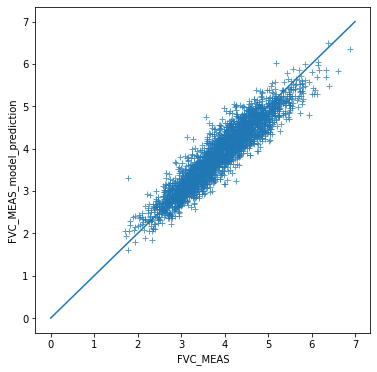

In [110]:
plt.figure(figsize = (6,6))
plt.scatter(df_target[col_y], df_target[col_y_pred], marker = "+", alpha = 0.7, linewidth = 1)
plt.plot([0,7], [0,7])
plt.xlabel(col_y)
plt.ylabel(f'{col_y}_model_prediction')
plt.show()

 num of 'M' subjects:  1867
 num of 'F' subjects:  820


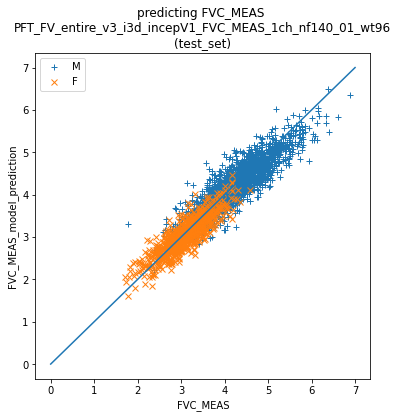

In [111]:
plt.figure(figsize = (6,6))
for _sex, _marker in zip(df_target["sex"].value_counts().index.values, ["+", "x"]):

    df_tmp = df_target[df_target["sex"] == _sex]
    print(f" num of '{_sex}' subjects: ", len(df_tmp))
    _y_true = df_tmp[col_y]
    _y_pred = df_tmp[col_y_pred]
    plt.scatter(_y_true, _y_pred , marker =_marker, linewidth = 1, label = _sex)
   
    
plt.plot([0,7], [0,7])
plt.legend()
plt.title(f"predicting {col_y} \n{tr_num}_wt{chosen_idx_of_weight}\n(test_set)")
# plt.savefig(os.path.join(PATH_trial, f"scatter_sq_{tr_num}_w{chosen_idx_of_weight}.png"))
plt.xlabel(col_y)
plt.ylabel(f'{col_y}_model_prediction')
plt.show()

count    2687.000000
mean        3.912869
std         0.808033
min         1.720000
25%         3.290000
50%         3.930000
75%         4.485000
max         6.890000
Name: FVC_MEAS, dtype: float64
count    2687.000000
mean        3.885452
std         0.772286
min         1.608847
25%         3.268863
50%         3.935850
75%         4.456592
max         6.499533
Name: modelpredicted(FVC_MEAS)_wt96, dtype: float64


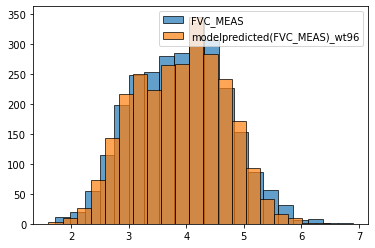

In [112]:
print(df_target[col_y].describe())
print(df_target[col_y_pred].describe())

df_target[col_y].hist(bins = 20, alpha = 0.7, ec = "k", grid = False, label = col_y)
df_target[col_y_pred].hist(bins = 20, alpha = 0.7, ec = "k", grid = False, label = col_y_pred)
plt.legend()

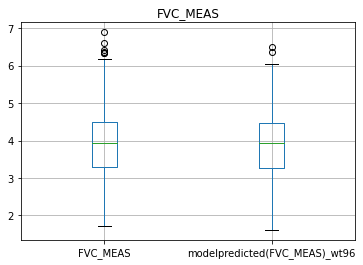

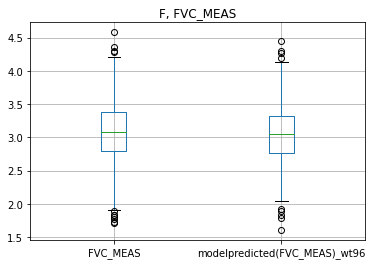

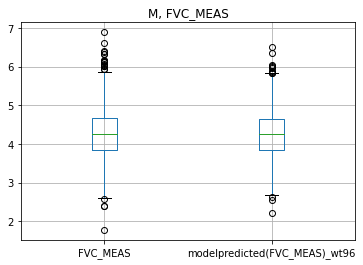

In [113]:
df_target.boxplot(column = [col_y, col_y_pred])
plt.title(col_y)
plt.show()

df_target[df_target["sex"] =="F"].boxplot(column = [col_y, col_y_pred])
plt.title(f"F, {col_y}")
plt.show()

df_target[df_target["sex"] =="M"].boxplot(column = [col_y, col_y_pred])
plt.title(f"M, {col_y}")
plt.show()

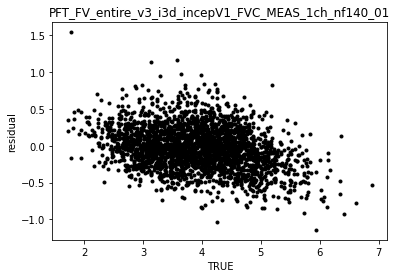

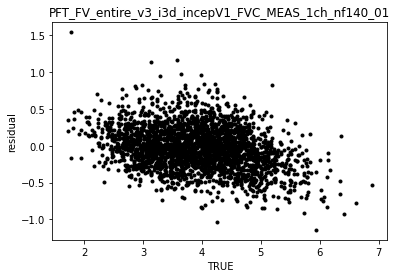

1.541478853225708 0.22260690510383893 0.28442976429476274 0.1834086227416991


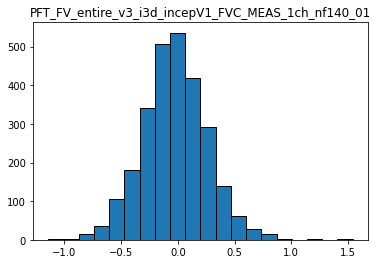

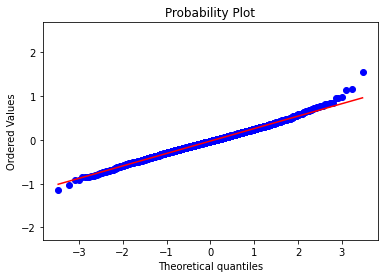

PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01 
 96
RMSE:  0.28569543149593085
MAE:  0.22260690510383893
R2_scipy:  0.8749422841370149
R2_cal: 0.8764765129940487

max resid:  1.541478853225708
mean resid:  0.22260690510383893
std resid:  0.28442976429476274
median resid:  0.1834086227416991


(0.28569543149593085,
 0.22260690510383893,
 0.8749422841370149,
 0.8764765129940487,
 1.541478853225708,
 0.1834086227416991)

In [114]:

y_true = df_target[col_y]
y_pred = df_target[col_y_pred]

get_residual_plot(y_true, y_pred)
get_evalutation_metrics(y_true, y_pred)

In [115]:
os.listdir(PATH_trial)

['weights',
 'tensorboard_log',
 'PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01_metric_testset.txt',
 'PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01_metric_trainset.txt',
 'df_train_result_PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01_weight_96_(210614).xlsx',
 'df_test_result_PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01_weight_96_(210614).xlsx',
 'scatter_sq_PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01_w96_train.png',
 'scatter_sq_PFT_FV_entire_v3_i3d_incepV1_FVC_MEAS_1ch_nf140_01_w96_test.png']

# % pred로 변환

0) 예측된 meas 값과, pred(reference) 값의 scatter plot을 그려 본다.

1) %pred 값을 계산해 본다. - 분포를 본다.  

2) 원래 계산된 %pred 값, 예측치로부터 계산된 %pred 값의 분포를 본다.



In [ ]:
# 0)
print(r2_score(df_target["FEV1_PRED"], df_target[col_y]))
plt.figure(figsize = (6,6))
plt.plot([0,7], [0,7])
plt.scatter( df_target["FEV1_PRED"],df_target[col_y], marker = "+", linewidth = 1)
plt.xlabel("FEV1_PRED(reference value)", fontsize = 15)
plt.ylabel(col_y, fontsize = 15)
plt.show()



print(r2_score(df_target["FEV1_PRED"], df_target[col_y_pred]))
plt.figure(figsize = (6,6))
plt.plot([0,7], [0,7])
plt.scatter( df_target["FEV1_PRED"],df_target[col_y_pred], marker = "+", linewidth = 1)
plt.xlabel("FEV1_PRED(reference value)", fontsize = 15)
plt.ylabel(col_y_pred, fontsize = 15)
plt.show()

In [ ]:
# 1) %pred 값을 계산해 본다. - 분포를 본다.
col_y_perpred_cal = "FEV1_percent_pred_using_prediction" 
# df_target[col_y_perpred_cal] = df_target[col_y_pred] /df_target["FEV1_PRED"] * 100

print(tr_num)
print("R2", r2_score(df_target["FEV1_%PRED"], df_target[col_y_perpred_cal]))
print(df_target[["FEV1_%PRED", col_y_perpred_cal]].describe())

#--------------------------------------
df_target[col_y_perpred_cal].hist(grid = False, bins = 20,ec = "k" , label = "%pred,\n calculated by model prediction")
df_target["FEV1_%PRED"].hist(grid = False, bins = 20,alpha = 0.3,  ec = "k", label = "%pred")
plt.xlabel("FEV1 %pred (%)")
plt.legend(loc = "best")
plt.title(tr_num)
plt.show()

#--------
plt.figure(figsize = (6,6))
plt.plot([45,140], [45,140])
plt.scatter( df_target["FEV1_%PRED"],df_target[col_y_perpred_cal], marker = "+", linewidth = 1)
plt.xlabel("FEV1_%PRED", fontsize = 15)
plt.ylabel(col_y_perpred_cal, fontsize = 15)
plt.xlim(45,140)
plt.ylim(45,140)
plt.show()








#----------

## 남녀에 따라 다른가?
plt.figure(figsize = (6,6))
# plt.plot([45,140], [45,140])


for _sex, _marker in zip(["F", "M"], ["+", "x"]):
    
    
    df_sex = df_target[df_target["sex"] == _sex]
    
    
    _x_axis =  np.array(df_sex["FEV1_%PRED"])
    _y_axis = np.array(df_sex[col_y_perpred_cal])
    
    print(_sex, _marker)
    print(np.min(_x_axis))
    print(df_sex["FEV1_%PRED"].describe())
    print(df_sex[col_y_perpred_cal].describe())
        

    print("----")
    plt.scatter( _x_axis,_y_axis , 
                marker = _marker, 
                alpha = 0.7,
                linewidth = 1, 
               label = _sex)
plt.legend()
plt.plot([45,140], [45,140])
plt.xlabel("FEV1_%PRED", fontsize = 15)
plt.ylabel("calculated %pred from model prediction ", fontsize = 15)
plt.xlim(45,140)
plt.ylim(45,140)
plt.show()





#----------


# plt.figure(figsize = (6,6))
# # plt.plot([45,140], [45,140])

# x_axis =  np.array(df_target["FEV1_%PRED"]) - np.array([100] * len(df_target))
# y_axis = np.array(df_target[col_y_perpred_cal]- df_target["FEV1_%PRED"])
# print("min resid", np.min(x_axis))
# print("describe resid\n", (df_target[col_y_perpred_cal]- df_target["FEV1_%PRED"]).describe())
# plt.scatter( x_axis,y_axis , 
#             marker = "+", 
#             linewidth = 1)
# plt.vlines(x = 0, ymin = -55, ymax = 55)
# plt.hlines(y = 0, xmin = -55, xmax = 55)
# plt.plot([-55, 55], [55,-55], color = "r")
# plt.xlabel("FEV1_%PRED - 100")
# plt.ylabel("calculated from model prediction - %predicted")
# # plt.ylabel(col_y_perpred_cal,"-","FEV1_%PRED" )
# plt.xlim(-55,55)
# plt.ylim(-55,55)
# plt.show()



## 남녀에 따라 다른가?
# plt.figure(figsize = (6,6))
# plt.plot([45,140], [45,140])


# for _sex, _marker in zip(["F", "M"], ["+", "x"]):
    
    
#     df_sex = df_target[df_target["sex"] == _sex]
    
    
#     _x_axis =  np.array(df_sex["FEV1_%PRED"]) - np.array([100] * len(df_sex))
#     _y_axis = np.array(df_sex[col_y_perpred_cal]- df_sex["FEV1_%PRED"])
    
#     print(_sex, _marker)
#     print(np.min(_x_axis))
#     print((df_sex[col_y_perpred_cal]- df_sex["FEV1_%PRED"]).describe())
#     print("----")
#     plt.scatter( _x_axis,_y_axis , 
#                 marker = _marker, 
#                 alpha = 0.4,
#                 linewidth = 1, 
#                label = _sex)
# plt.legend()
# plt.vlines(x = 0, ymin = -55, ymax = 55)
# plt.hlines(y = 0, xmin = -55, xmax = 55)
# plt.plot([-55, 55], [55,-55], color = "r")
# plt.xlabel("FEV1_%PRED - 100")
# plt.ylabel("calculated from model prediction - %predicted")
# # plt.ylabel(col_y_perpred_cal,"-","FEV1_%PRED" )
# plt.xlim(-55,55)
# plt.ylim(-55,55)
# plt.show()

dict_sex_sub = {}
for _sex, _marker in zip(["F", "M"], ["+", "x"]):
    
    
    df_sex = df_target[df_target["sex"] == _sex]
    _name = _sex + "_residual"
    print(_name)
    dict_sex_sub[_name] = np.array(df_sex[col_y_perpred_cal]- df_sex["FEV1_%PRED"])
    
    (df_sex[col_y_perpred_cal]- df_sex["FEV1_%PRED"]).hist(alpha = 0.3, 
                                                           ec = "k", 
                                                           grid = False,
                                                          bins = np.arange(-30, 30, 3), 
                                                          label = _sex)
    plt.xlabel("residual")
plt.legend()
plt.show()

# for _sex, _marker in zip(["F", "M"], ["+", "x"]):
    
    
#     df_sex = df_target[df_target["sex"] == _sex]
#     _resid_sexsub = df_sex[col_y_perpred_cal]- df_sex["FEV1_%PRED"]
#     sp.stats.probplot(_resid_sexsub, plot = plt)
# #     plt.axis("equal")
#     plt.show()





In [ ]:
# https://pythonfordatascienceorg.wordpress.com/paired-samples-t-test-python/#what-is-it

In [ ]:
from scipy import stats

In [ ]:
#perform two sample t-test with equal variances
stats.ttest_ind(dict_sex_sub["F_residual"], dict_sex_sub["M_residual"],
                equal_var = True)

In [ ]:
stats.ttest_ind(dict_sex_sub["F_residual"], dict_sex_sub["M_residual"],
                equal_var = False)

In [ ]:
# https://www.geeksforgeeks.org/linear-regression-python-implementation/#:~:text=Linear%20Regression%20(Python%20Implementation)%20This%20article%20discusses%20the,variable%20with%20a%20given%20set%20of%20independent%20variables.

import numpy as np
import matplotlib.pyplot as plt
 
def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)
 
    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)
 
    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x
 
    # calculating regression coefficients
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x
 
    return (b_0, b_1)
 
def plot_regression_line(x, y, b):
    # plotting the actual points as scatter plot
    plt.figure(figsize = (6,6))
    
    plt.scatter(x, y, color = "m",
               marker = "+", 
#                 s = 10,
               linewidth = 1
               )
 
    # predicted response vector
    y_pred = b[0] + b[1]*x
 
    # plotting the regression line
    plt.plot(x, y_pred, color = "g")
    # plot identical line
    plt.plot([0,7], [0,7])
    # putting labels
    plt.xlabel('x')
    plt.ylabel('y')
 
    # function to show plot
    plt.show()
 
def main():
    # observations / data
    x = df_target["FEV1_PRED"]
    y = df_target[col_y_pred]
 
    # estimating coefficients
    b = estimate_coef(x, y)
    print("Estimated coefficients:\nb_0 = {}  \
          \nb_1 = {}".format(b[0], b[1]))
 
    # plotting regression line
    plot_regression_line(x, y, b)
 
if __name__ == "__main__":
    main()

In [ ]:
b = estimate_coef(df_target["FEV1_PRED"], df_target[col_y_pred])

In [ ]:
os.listdir(PATH_trial)

In [ ]:
df_target.keys()

In [ ]:
y_percent_pred = df_target[col_y_perpred_cal]
y_percent_true = df_target["FEV1_%PRED"]

get_residual_plot(y_percent_true, y_percent_pred)
get_evalutation_metrics(y_percent_true, y_percent_pred)

In [ ]:
save_path = os.path.join(PATH_trial,f"df_test_result_{tr_num}_weight_{chosen_idx_of_weight}_({now}).xlsx")
df_target.to_excel(save_path)

<hr>

# for CAM

In [ ]:
df_target

In [ ]:
df_target[col_y].max(), df_target[col_y].min()

In [ ]:
(5.2-1.3)/13

In [ ]:
col_y_pred

In [ ]:
list_range

In [ ]:
col_y_pred_zsc = "zscore_residuals_weight117"

criteria_1 = abs(df_target[col_y_pred_zsc])<=0.3

list_range = np.arange(1.3, 5.3, 0.3)
df_sample_2 = pd.DataFrame()
for _i in range(len(list_range[:-1])):
    criteria_2 = (df_target[col_y] >=list_range[_i]) &  (df_target[col_y] <list_range[_i+1])
    df_tmp = df_target[criteria_1& criteria_2 ].sample(n = 1)
    
    df_sample_2= pd.concat([df_sample_2, df_tmp], axis = 0, ignore_index = True)
    print(df_sample_2.shape)
print(df_sample_2.shape)

In [ ]:
np.max(df_target[col_y])

In [ ]:
df_target[df_target[col_y] > 4.9][[col_y, col_y_pred]]

In [ ]:
criteria_2 = (df_target[col_y] >=4.9)
print(df_target[criteria_2 ].shape)
df_tmp = df_target[ criteria_2 ].sample(n = 1)

df_sample_2= pd.concat([df_sample_2, df_tmp], axis = 0, ignore_index = True)

In [ ]:
df_sample = df_sample_2.copy()
df_sample = df_sample.reset_index(drop = True)
print(df_sample.shape)
plt.figure(figsize = (6,6))

for _sex, _color, _marker in zip(["F", "M"],["red", "blue"], ["+", "x"]):
    _sample_sub = df_sample[df_sample["sex"] == _sex]
    _target_sub = df_target[df_target["sex"] == _sex]
    
    plt.scatter(_target_sub[col_y], _target_sub[col_y_pred],marker = _marker , color = _color,label = f"{_sex}", linewidth = 1, alpha = 0.2)
    plt.scatter(_sample_sub[col_y], _sample_sub[col_y_pred], color = _color , label = f"sample_{_sex}")
    
    
    
plt.legend() 
plt.plot([1,6], [1,6])
plt.title("12 samples extracted from testset ")
plt.xlabel(col_y)
plt.ylabel(col_y_pred)

In [ ]:



plt.scatter(df_sample[col_y], df_sample[col_y_pred])

In [ ]:
list_sample_ID = df_sample["examID"].tolist()
print(list_sample_ID)
print(len(list_sample_ID))

In [ ]:
list_conv_idx = []

for i, layer in enumerate(model.layers):

    if 'conv' not in layer.name:
        continue
        
    else:
#         print(i, layer.name)
#         print(layer.input.shape)
#         print(layer.kernel_size, layer.strides)
#         print(layer.output.shape)
#         print("------------------")
        list_conv_idx.append(i)
print(list_conv_idx)

list_mixed_idx = []

for i, layer in enumerate(model.layers):

    if 'Mixed' not in layer.name:
        continue
        
    else:
#         print(i, layer.name)
#         print(layer.output.shape)
#         print(layer.get_config())
        list_mixed_idx.append(i)
print(list_mixed_idx)

In [ ]:
weightpath=os.path.join(os.path.join(PATH_trial,'weights','train_weights_epoch_{}.h5').format(str(chosen_idx_of_weight).zfill(3)))
print(weightpath)
model.load_weights(weightpath)

In [ ]:
def load_array(_path, _yidx):     
    
    img_3d = sitk.GetArrayFromImage(sitk.ReadImage(_path))
        


    list_range = np.arange(0, img_3d.shape[1],1)


    for _, _idx in enumerate(list_range):
        img_tmp = np.flipud(img_3d[:, _idx, :])
        img_tmp = np.expand_dims(img_tmp, axis = 0)

        if _ == 0:
            img_out = img_tmp[:]
        else:
            img_out = np.concatenate([img_out, img_tmp], axis = 0)
    return img_out


In [ ]:
def save_to_3d(_IMG, _SAVE_PATH , _ID):
    img= sitk.GetImageFromArray(_IMG)    
    output_filename = os.path.join(_SAVE_PATH, f"{_ID}.hdr")
    print(output_filename)
    sitk.WriteImage(img, output_filename)

In [ ]:
def GradCAM_3d(_model, _IMG, _layer_idx):
#------------------------from f schollet
    preds = _model.predict(_IMG)
    class_idx = np.argmax(preds[0])
    class_output = _model.output[:, class_idx]
    last_conv_layer = _model.get_layer(_model.layers[_layer_idx].name)
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2, 3))  # 이거 확인. # 전체 feature 에 대해서 각 피처별로 mean을 구함.
    iterate = K.function([_model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([_IMG])
    for i in range(conv_layer_output_value.shape[-1]):
        conv_layer_output_value[..., i] *= pooled_grads_value[i]


    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)   
    averaged_featuremap = np.copy(heatmap)
    return averaged_featuremap

In [ ]:
def get_layer_op(_model, _IMG, _layer_idx):
    tmp_model = Model(inputs=_model.input, outputs=_model.layers[_layer_idx].output)
    feature_maps = tmp_model.predict(_IMG)
    averaged_featuremap = np.average(feature_maps, axis = -1)
    return averaged_featuremap 

In [ ]:
def plot_3D_rough(_IMG_3D, n_cols = 5):
    # y, z, x
    n_cols = n_cols
    n_rows = _IMG_3D.shape[0]//n_cols if _IMG_3D.shape[0]%n_cols==0 else _IMG_3D.shape[0]//n_cols +1

    f, a = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = (3 * n_cols+3, 3 * n_rows))

    for _slice_idx in range(_IMG_3D.shape[0]):
        _col = _slice_idx%n_cols
        _row = _slice_idx //n_cols
        _slice_feature = _IMG_3D[ _slice_idx, :, :]
        if n_rows !=1:
            im = a[_row, _col].imshow(_slice_feature, 
                                 cmap = "jet", 
#                                     vmin = 0,
#                                     vmax = 1
                                )   
            a[_row, _col].axis("off")
        elif n_rows ==1:
            im = a[_col].imshow(_slice_feature, 
                 cmap = "jet", 
#                     vmin = 0,
#                     vmax = 1
                )   
            a[ _col].axis("off")
#         f.colorbar(im, ax = a.ravel().tolist())
    plt.tight_layout()       
    plt.show()
    plt.close(f)

In [ ]:
def resize_heatmap(_target_img, _heatmap, _op_dimension= 3):
    ''' 
    PFT
    _target_img : input image. 5 dimension (batch size, number of frames, z(num rows), x(num cols), ch)  = (batch, y, z, x,)  사실 현재 (y, -z, x) 상태
    _heatmap : layer output OR activated map 
    '''
    
    TARGET_NF,TARGET_HEIGHT,TARGET_WIDTH   = _target_img.shape[1], _target_img.shape[2], _target_img.shape[3]
    if len(_heatmap.shape) ==4:
        _heatmap = np.squeeze(_heatmap, axis = 0)
    
    # 이미지의 크기로 reshaping 하는 과정. 이거 np나 cv2에서 있을 것이므로 다시 찾아 도전하자. 
    resized_featuremap = np.zeros((_heatmap.shape[0], TARGET_HEIGHT, TARGET_WIDTH))
    for _frame_idx in range(_heatmap.shape[0]):
        _slice = _heatmap[_frame_idx, :, :]
        _resized_slice = cv2.resize(_slice,(TARGET_WIDTH, TARGET_HEIGHT), interpolation = cv2.INTER_CUBIC )   # 가로 세로 순이다. numpy array와 순서가 다르다. 
        resized_featuremap[_frame_idx, :, :] = _resized_slice

    # 2) y aixs = frame,  axis = 0에 대해서 (frame, 행개수(높이), 열개수(가로)  for 문을 돌리면서, resize 하여 쌓는다.
    _heatmap = np.copy(resized_featuremap)
    resized_featuremap = np.zeros((TARGET_NF, TARGET_HEIGHT, TARGET_WIDTH) )
    for _frame_idx in range(_heatmap.shape[2]):
        _slice = _heatmap[ :, :,_frame_idx]
        _resized_slice = cv2.resize(_slice,( TARGET_HEIGHT, TARGET_NF), interpolation = cv2.INTER_CUBIC )
        resized_featuremap[ :, :,_frame_idx] = _resized_slice

    _heatmap = np.copy(resized_featuremap)  
    # 이것을 저장하면 된다. 
    

    # 차원을 증가시켜서 그리는데, 굳이 그럴 필요는 없는 것 같지만 우선 이렇게 정의 한다.
    if _op_dimension == 4:
        _heatmap= np.expand_dims(_heatmap, axis = 0)
    return _heatmap

In [ ]:
def min_max(_IMGARRAY):
    _np_ar = _IMGARRAY.copy()
    _np_ar = (_np_ar - np.min(_np_ar)) / (np.max(_np_ar) - np.min(_np_ar))
    return _np_ar
def make_type_to_int(_IMGARRAY):
    _np_ar = _IMGARRAY.copy()
    _np_ar *=255
    _np_ar = _np_ar.astype(np.uint8)
    return _np_ar

In [ ]:
# import shutil


# PATH_CAM_sample = "/workspace/nas100_vol2/projects/04_PFT/data/Toy2_3000/CAM_sample_0324"
# if not os.path.isdir(PATH_CAM_sample):
#     os.mkdir(PATH_CAM_sample)


# #--------------------------------------
# df_tmp = df_sample # 크신 분은 testset이 아니시다.
# print(df_tmp.shape)
# list_layeridx2show =list_conv_idx[:1] list_mixed_idx[-5:-2]


# #--------------------------------------
# for i, _row in df_tmp.iterrows():
#     print(i)
#     _examID = _row['HE0108(R5253A)검사접수번호']
#     _path = os.path.join(PATH_input, f"{_examID}.hdr" )
#     _path_img = os.path.join(PATH_input, f"{_examID}.img" )
    
#     try:
#         shutil.copy2(_path, PATH_CAM_sample)
#     except OSError as err:
#         print(err)
#     try:
#         shutil.copy2(_path_img, PATH_CAM_sample)
#     except OSError as err:
#         print(err)
    
        
    
#     print(_path)
#     _y_idx = _row["y_idx"]

#     img_3d = load_array(_path, _y_idx)  # 주피터 노트북 출력시 이용
    

    
#     img = load_image(_path, _y_idx)     # model predict시 이용.
# #     save_to_3d(img_3d, PATH_CAM_sample, "img_3d_by_load_array")
# #     save_to_3d(img, PATH_CAM_sample, "img_by_load_image")
    
#     img = np.expand_dims(img, axis = 0)
    
    
    
    
#     print(img_3d.shape)
#     print(img.shape)

#     for _idx in list_layeridx2show:
#         layer_name = model.layers[_idx].name
#         print( layer_name)


        
        
#         grad_CAM = GradCAM_3d(model, img, _idx)

# #         averaged_featuremap = np.copy(heatmap) # 3차원이 되었다. 
# #         print(grad_CAM.shape)
# #         plot_3D_rough(grad_CAM, n_cols = 10)
        

#         grad_CAM = resize_heatmap(img, grad_CAM)
        
        
#         #-------------
#         grad_CAM = min_max(grad_CAM)
#         grad_CAM = make_type_to_int(grad_CAM)

        
#         moveaxis_grad_CAM = np.moveaxis(grad_CAM, [0,1], [1,0])
#         moveaxis_grad_CAM = moveaxis_grad_CAM[::-1,:,:]
        
#         print(grad_CAM.shape)
#         grad_CAM_savename = f"{i}_{_examID}_{col_y}_{layer_name}"
#         save_to_3d(moveaxis_grad_CAM, PATH_CAM_sample, grad_CAM_savename)
        
#         print("------------------> saved: ", grad_CAM_savename)
#         if _idx == 5:
#             plot_3D_rough(grad_CAM, n_cols = 10)
        

        
# #     break
        
        
        

In [ ]:
import shutil

# PATH_CAM_sample = "/workspace/nas100_vol2/projects/04_PFT/data/Toy2_3000/CAM_sample_0324"
PATH_CAM_sample = "/workspace/nas100_vol2/projects/04_PFT/data/Toy2_3000/LAYER_OP_sample_0324"
if not os.path.isdir(PATH_CAM_sample):
    os.mkdir(PATH_CAM_sample)


#--------------------------------------
df_tmp = df_sample # 크신 분은 testset이 아니시다.
print(df_tmp.shape)
list_layeridx2show =list_conv_idx[:1] + list_mixed_idx[-5:-3]


#--------------------------------------
for i, _row in df_tmp.iterrows():
    print(i)
    _examID = _row['HE0108(R5253A)검사접수번호']
    _path = os.path.join(PATH_input, f"{_examID}.hdr" )
    _path_img = os.path.join(PATH_input, f"{_examID}.img" )
    
    try:
        shutil.copy2(_path, PATH_CAM_sample)
    except OSError as err:
        print(err)
    try:
        shutil.copy2(_path_img, PATH_CAM_sample)
    except OSError as err:
        print(err)
    
        
    
    print(_path)
    _y_idx = _row["y_idx"]

    img_3d = load_array(_path, _y_idx)  # 주피터 노트북 출력시 이용
    

    
    img = load_image(_path, _y_idx)     # model predict시 이용.
#     save_to_3d(img_3d, PATH_CAM_sample, "img_3d_by_load_array")
#     save_to_3d(img, PATH_CAM_sample, "img_by_load_image")
    
    img = np.expand_dims(img, axis = 0)
    
    
    
    
    print(img_3d.shape)
    print(img.shape)

    for _idx in list_layeridx2show:
        layer_name = model.layers[_idx].name
        print( layer_name)

        ##############
        ## GradCAM  ##
        ##############
        
    
#         grad_CAM = GradCAM_3d(model, img, _idx)

# #         print(grad_CAM.shape)
# #         plot_3D_rough(grad_CAM, n_cols = 10)
        

#         grad_CAM = resize_heatmap(img, grad_CAM)
        
        
#         #-------------
#         grad_CAM = min_max(grad_CAM)
#         grad_CAM = make_type_to_int(grad_CAM)

        
#         moveaxis_grad_CAM = np.moveaxis(grad_CAM, [0,1], [1,0])
#         moveaxis_grad_CAM = moveaxis_grad_CAM[::-1,:,:]
        
#         print(grad_CAM.shape)
#         grad_CAM_savename = f"{i}_{_examID}_{col_y}_{layer_name}"
#         save_to_3d(moveaxis_grad_CAM, PATH_CAM_sample, grad_CAM_savename)
        
#         print("------------------> saved: ", grad_CAM_savename)
#         if _idx == 5:
#             plot_3D_rough(grad_CAM, n_cols = 10)

        #######################
        ## AM: layer output  ##
        #######################



        layer_op = get_layer_op(model, img, _idx)
        plt.hist(layer_op.ravel())
        plt.title(f"{_examID}_{layer_name}")
        plt.show()
        print("min: ", np.min(layer_op))
        print("max: ", np.max(layer_op))
#         plot_3D_rough(layer_op, n_cols=10)
        
#         layer_op = np.maximum(layer_op, 0) 
        print(layer_op.shape)

        
        layer_AM = resize_heatmap(img, layer_op)
        
        
        #-------------
        layer_AM = min_max(layer_AM)
        layer_AM = make_type_to_int(layer_AM)

        
        moveaxis_layer_AM = np.moveaxis(layer_AM, [0,1], [1,0])
        moveaxis_layer_AM = moveaxis_layer_AM[::-1,:,:]
        
        print(grad_CAM.shape)
        _savename = f"{i}_{_examID}_{col_y}_{layer_name}"
        save_to_3d(moveaxis_layer_AM, PATH_CAM_sample, _savename)
        
        
        
        print(layer_op.shape)

#         break
#     break
        
        
        

In [ ]:
# for _i, _row in df_sample.iterrows():
#     _ID = _row["examID"]
#     list_files = glob.glob(os.path.join(PATH_CAM_sample, f"*{_ID}*"))
# #     print(list_files)
#     print(len(list_files))
    
#     _dir_ID = os.path.join(PATH_CAM_sample, f"{_i}_{_ID}")
#     print(_dir_ID)
#     if not os.path.isdir(_dir_ID):
#         os.mkdir(_dir_ID)
        
#     for _file in list_files:
#         shutil.move(_file, _dir_ID)
        
# #     break

In [ ]:
df_sample.to_excel(os.path.join(PATH_CAM_sample, f"df_sample.xlsx"))

# merge data from FVC meas

In [ ]:
list_column = ["examID", "ID_path", 'y_idx', 'modelpredicted(FVC_MEAS)_wt130', 'residuals_wt130',
       'zscore_residuals_weight130']
df_FVC = pd.read_excel( os.path.join('/workspace/nas100_vol2/projects/04_PFT/PFT_TOY2_I3D_regression_with_preprocessing_v2/result_PFT_TOY2_v2_i3d_incepV1_FVC_MEAS_1ch_nf140_00/df_test_result_PFT_TOY2_v2_i3d_incepV1_FVC_MEAS_1ch_nf140_00_weight_130_(210322).xlsx'),
                      usecols = list_column)

In [ ]:
df_FVC.head()

In [ ]:
df_target.head()

In [ ]:
df_target.shape

In [ ]:
df_target = pd.merge(df_target, df_FVC, on = ["examID", "ID_path"] )

In [ ]:
PATH_test_result = os.path.join(PATH_info, "Test_Result")
if not os.path.isdir(PATH_test_result):
    os.mkdir(PATH_test_result)
save_path = os.path.join(PATH_test_result, f"PFT_LDCT_TEST_Toy599(210324).xlsx" )
print(save_path)

In [ ]:
df_target.to_excel(save_path)